In [ ]:
!pip uninstall torchaudio
!pip uninstall torchdata
!pip uninstall torchsummary
!pip uninstall torchtext
!pip uninstall torchvision

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):
  ! {sys.executable} -m pip install pytorch-lifestream
  !pip install "torch<2"
  !pip install torchvision==0.13.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import pytorch_lightning as pl

from sklearn.metrics import accuracy_score, classification_report


from sklearn.model_selection import KFold
import logging

from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
%matplotlib inline



from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F

In [ ]:
import os
import pandas as pd

data_path = '/content/drive/MyDrive/data_age_pred/'

source_data = pd.read_csv(os.path.join(data_path, 'transactions_train.csv'))
source_data.head(2)

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017


In [ ]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='client_id',
    col_event_time='trans_date',
    event_time_transformation='none',
    cols_category=['small_group'],
    cols_numerical=['amount_rur'],
    return_records=True,
)

In [ ]:
%%time

dataset = preprocessor.fit_transform(source_data)

CPU times: user 1min 1s, sys: 14.6 s, total: 1min 15s
Wall time: 1min 19s


In [ ]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
dataset = sorted(dataset, key=lambda x: x['client_id'])

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(24000, 6000)

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'log'},
    embeddings={
        'trans_date': {'in': 800, 'out': 16},
        'small_group': {'in': 250, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=ColesDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[
                SeqLenFilter(min_seq_len=25),
            ],
        ),
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=200,
        ),
    ),
    train_num_workers=2,
    train_batch_size=256,
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=300,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


logger.version = 0


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 240 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.962     Total estimated model params size (MB)


{'loss': tensor(255.2669), 'seq_len': tensor(111.7979)}
CPU times: user 1h 32min 36s, sys: 5min 40s, total: 1h 38min 16s
Wall time: 2h 7min 24s


In [ ]:
torch.save(seq_encoder.state_dict(), "coles_emb.pt")

In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([24000, 256]), torch.Size([6000, 256]))

In [ ]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

print(train_df.shape, test_df.shape)

(24000, 258) (6000, 258)


In [ ]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

# LGBM

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    n_estimators=1000,
    boosting_type='gbdt',
    objective='multiclass',
    num_class=4,
    metric='multi_error',
    learning_rate=0.02,
    subsample=0.75,
    subsample_freq=1,
    feature_fraction=0.75,
    colsample_bytree=None,
    max_depth=12,
    lambda_l1=1,
    reg_alpha=None,
    lambda_l2=1,
    reg_lambda=None,
    min_data_in_leaf=50,
    min_child_samples=None,
    num_leaves=50,
    random_state=42,
    n_jobs=4,
)

In [ ]:
lgb_clf.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 256
[LightGBM] [Info] Start training from score -1.381141
[LightGBM] [Info] Start training from score -1.384795
[LightGBM] [Info] Start training from score -1.391642
[LightGBM] [Info] Start training from score -1.387629


LGBMClassifier(colsample_bytree=None, feature_fraction=0.75, lambda_l1=1,
               lambda_l2=1, learning_rate=0.02, max_depth=12,
               metric='multi_error', min_child_samples=None,
               min_data_in_leaf=50, n_estimators=1000, n_jobs=4, num_class=4,
               num_leaves=50, objective='multiclass', random_state=42,
               reg_alpha=None, reg_lambda=None, subsample=0.75,
               subsample_freq=1)

In [ ]:
clf_res = lgb_clf.score(x_test, y_test)

In [ ]:
clf_res

0.6393333333333333

# Down stream task


In [ ]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 800, 'out': 16},
        'small_group': {'in': 250, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

seq_encoder.load_state_dict(torch.load('coles_emb.pt'))


In [ ]:
from functools import partial
import torch
import torchmetrics
from ptls.frames.supervised import SequenceToTarget
from ptls.nn import Head

downstream_model = SequenceToTarget(
    seq_encoder=seq_encoder,
    head=Head(
        input_size=seq_encoder.embedding_size,
        use_batch_norm=True,
        objective='classification',
        num_classes=4,
    ),
    loss=torch.nn.NLLLoss(),
    metric_list=torchmetrics.Accuracy(compute_on_step=False),
    pretrained_lr=0.0001,
    optimizer_partial=partial(torch.optim.Adam, lr=0.01, weight_decay = 0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.2),
)

In [ ]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))
df_target.set_index('client_id', inplace=True)
df_target.rename(columns={"bins": "target"}, inplace=True)

In [ ]:
for el in dataset:
    el['target'] = df_target['target'][el['client_id']]

In [ ]:
train, valid = train_test_split(train, test_size=0.1, random_state=42)

len(train), len(valid), len(test)

In [ ]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.frames.supervised import SeqToTargetDataset
from ptls.frames import PtlsDataModule

def get_dataset(data):
    return SeqToTargetDataset(
        MemoryMapDataset(
            data=data,
        ),
        target_col_name='target',
    )

finetune_dm = PtlsDataModule(
    train_data=get_dataset(train),
    valid_data=get_dataset(valid),
    test_data=get_dataset(test),
    train_num_workers=4,
    train_batch_size=256,
    test_batch_size=128,
)

In [ ]:
trainer_ft = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

In [ ]:
print(f'logger.version = {trainer_ft.logger.version}')
trainer_ft.fit(downstream_model, finetune_dm)
print(trainer_ft.logged_metrics)

In [ ]:
trainer_ft.test(downstream_model, dataloaders=finetune_dm.test_dataloader())

In [ ]:
train_dl_ft = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds_ft = torch.vstack(trainer_ft.predict(downstream_model, train_dl_ft, ))

test_dl_ft = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds_ft = torch.vstack(trainer_ft.predict(downstream_model, test_dl_ft))

train_embeds_ft.shape, test_embeds_ft.shape

In [ ]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df_ft = pd.DataFrame(data=train_embeds_ft, columns=[f'embed_{i}' for i in range(train_embeds_ft.shape[1])])
train_df_ft['client_id'] = [x['client_id'] for x in train]
train_df_ft = train_df_ft.merge(df_target, how='left', on='client_id')

test_df_ft = pd.DataFrame(data=test_embeds_ft, columns=[f'embed_{i}' for i in range(test_embeds_ft.shape[1])])
test_df_ft['client_id'] = [x['client_id'] for x in test]
test_df_ft = test_df_ft.merge(df_target, how='left', on='client_id')

print(train_df_ft.shape, test_df_ft.shape)

In [ ]:
embed_columns = [x for x in train_df_ft.columns if x.startswith('embed')]
x_train_ft, y_train_ft = train_df_ft[embed_columns], train_df_ft['target']
x_test_ft, y_test_ft = test_df_ft[embed_columns], test_df_ft['target']

In [ ]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train_ft, y_train_ft)
y_pred_forest = clf_forest.predict(x_test_ft)
print('accuracy for random forest:', clf_forest.score(x_test_ft, y_test_ft))

In [ ]:
lgb_clf.fit(x_train_ft, y_train_ft)

In [1]:
lgb_clf.score(x_test_ft, y_test_ft)

0.6298


# One - vs - Rest

In [ ]:
clf_ovsr = OneVsRestClassifier(LinearSVC(random_state=42, max_iter=100000)).fit(x_train, y_train)
y_pred_ovsr = clf_ovsr.predict(x_test)
accuracy_ovsr = accuracy_score(y_test, y_pred_ovsr)
report_ovsr = classification_report(y_test, y_pred_ovsr)
print(f"Accuracy One vs Rest: {accuracy_ovsr}")
print("Classification Report One vs Rest:\n", report_ovsr)

Accuracy One vs Rest: 0.6306666666666667
Classification Report One vs Rest:
               precision    recall  f1-score   support

           0       0.48      0.46      0.47      1403
           1       0.70      0.75      0.72      1488
           2       0.75      0.82      0.78      1592
           3       0.55      0.47      0.51      1517

    accuracy                           0.63      6000
   macro avg       0.62      0.63      0.62      6000
weighted avg       0.62      0.63      0.62      6000



# One - vs - One

In [ ]:
clf_ovso = OneVsOneClassifier(LinearSVC(random_state=42, max_iter=100000)).fit(x_train, y_train)
y_pred_ovso =clf_ovso.predict(x_test)
accuracy_ovso = accuracy_score(y_test, y_pred_ovso)
report_ovso = classification_report(y_test, y_pred_ovso)
print(f"Accuracy One vs One: {accuracy_ovso}")
print("Classification Report One vs One:\n", report_ovso)

Accuracy One vs One: 0.6375
Classification Report One vs One:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49      1403
           1       0.73      0.72      0.73      1488
           2       0.78      0.80      0.79      1592
           3       0.54      0.52      0.53      1517

    accuracy                           0.64      6000
   macro avg       0.63      0.63      0.63      6000
weighted avg       0.64      0.64      0.64      6000



# LSTM

In [ ]:
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.dropout(lstm_out)
        output = self.fc1(output)
        return output

In [ ]:
@torch.no_grad()
def test(model,criterion, loader, tqdm_desc):
    model.eval()
    acc = 0.0
    loss = 0.0
    for data, target in tqdm(loader, desc=tqdm_desc):
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        cur_loss = criterion(output.squeeze(), target)

        acc += (output.argmax(dim=1) == target).sum().item()
        loss += cur_loss.item() * target.shape[0]

    acc /= len(val_loader.dataset)
    loss /= len(val_loader.dataset)

    return loss, acc

def train_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    model.train()
    acc = 0.0
    loss = 0.0
    for data, target in tqdm(train_loader, desc=tqdm_desc):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)

        l = criterion(output.squeeze(), target)
        l.backward()

        acc += (output.argmax(dim=1) == target).sum()
        loss += l.item() * target.shape[0]
        optimizer.step()
    acc /= len(train_loader.dataset)
    loss /= len(train_loader.dataset)
    return loss, acc

def train(model, optimizer, criterion, scheduler,train_loader,  val_loader, n_epochs):
    train_loss = 0.0
    train_acc = 0.0

    val_loss = 0.0
    val_acc = 0.0
    train_losses = []
    val_losees = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader,  f'Training epoch {epoch + 1} /{n_epochs}')
        val_loss, val_acc = test(model,criterion, val_loader,  f'Validating epoch {epoch + 1}/{n_epochs}')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_losees.append(val_loss)



        print(f"Epoch {epoch + 1}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step(val_loss)
    return train_losses, val_losees, train_accuracies, val_accuracies



In [ ]:
num_epochs = 100

batch_size = 64
dropout_prob = 0.3
hidden_size = 256

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



layer_dim = 1





model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = None



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/100: 100%|██████████| 75/75 [00:00<00:00, 256.70it/s]


Epoch 1
 train loss: 1.3742414744695028, train acc: 0.3244791626930237
 val loss: 1.3623210446039835, val acc: 0.42333333333333334



Validating epoch 2/100: 100%|██████████| 75/75 [00:00<00:00, 333.83it/s]


Epoch 2
 train loss: 1.3508643436431884, train acc: 0.4149479269981384
 val loss: 1.3359596506754556, val acc: 0.47604166666666664



Validating epoch 3/100: 100%|██████████| 75/75 [00:00<00:00, 329.28it/s]


Epoch 3
 train loss: 1.3210423998037975, train acc: 0.4632812738418579
 val loss: 1.2995926984151205, val acc: 0.49291666666666667



Validating epoch 4/100: 100%|██████████| 75/75 [00:00<00:00, 328.01it/s]


Epoch 4
 train loss: 1.2780759179592132, train acc: 0.4818750023841858
 val loss: 1.2495625257492065, val acc: 0.5116666666666667



Validating epoch 5/100: 100%|██████████| 75/75 [00:00<00:00, 508.55it/s]


Epoch 5
 train loss: 1.2241832466920217, train acc: 0.4989062547683716
 val loss: 1.18763174533844, val acc: 0.51875



Validating epoch 6/100: 100%|██████████| 75/75 [00:00<00:00, 463.42it/s]


Epoch 6
 train loss: 1.1613592255115508, train acc: 0.5103124976158142
 val loss: 1.1230625184377034, val acc: 0.5204166666666666



Validating epoch 7/100: 100%|██████████| 75/75 [00:00<00:00, 498.06it/s]


Epoch 7
 train loss: 1.101206621925036, train acc: 0.5249479413032532
 val loss: 1.0595228672027588, val acc: 0.545625



Validating epoch 8/100: 100%|██████████| 75/75 [00:00<00:00, 481.12it/s]


Epoch 8
 train loss: 1.0453880621989569, train acc: 0.5469791889190674
 val loss: 1.0051599009831746, val acc: 0.566875



Validating epoch 9/100: 100%|██████████| 75/75 [00:00<00:00, 481.23it/s]


Epoch 9
 train loss: 1.0014948147535323, train acc: 0.5626562833786011
 val loss: 0.9668513441085815, val acc: 0.5795833333333333



Validating epoch 10/100: 100%|██████████| 75/75 [00:00<00:00, 470.59it/s]


Epoch 10
 train loss: 0.9721512877941132, train acc: 0.5702083706855774
 val loss: 0.9403943745295207, val acc: 0.5895833333333333



Validating epoch 11/100: 100%|██████████| 75/75 [00:00<00:00, 334.09it/s]


Epoch 11
 train loss: 0.951815318663915, train acc: 0.5759896039962769
 val loss: 0.9236538688341777, val acc: 0.5997916666666666



Validating epoch 12/100: 100%|██████████| 75/75 [00:00<00:00, 320.14it/s]


Epoch 12
 train loss: 0.9389312603076299, train acc: 0.5772395730018616
 val loss: 0.9087418365478516, val acc: 0.6041666666666666



Validating epoch 13/100: 100%|██████████| 75/75 [00:00<00:00, 507.78it/s]


Epoch 13
 train loss: 0.9309269922971726, train acc: 0.5843750238418579
 val loss: 0.9003264609972635, val acc: 0.6



Validating epoch 14/100: 100%|██████████| 75/75 [00:00<00:00, 493.52it/s]


Epoch 14
 train loss: 0.9221562095483145, train acc: 0.5869271159172058
 val loss: 0.8902074480056763, val acc: 0.610625



Validating epoch 15/100: 100%|██████████| 75/75 [00:00<00:00, 502.57it/s]


Epoch 15
 train loss: 0.9147780193885168, train acc: 0.5901041626930237
 val loss: 0.8830188004175822, val acc: 0.60875



Validating epoch 16/100: 100%|██████████| 75/75 [00:00<00:00, 494.09it/s]


Epoch 16
 train loss: 0.9111950234572093, train acc: 0.589062511920929
 val loss: 0.8771362249056498, val acc: 0.614375



Validating epoch 17/100: 100%|██████████| 75/75 [00:00<00:00, 473.08it/s]


Epoch 17
 train loss: 0.9060533161958059, train acc: 0.5952604413032532
 val loss: 0.871901859442393, val acc: 0.6166666666666667



Validating epoch 18/100: 100%|██████████| 75/75 [00:00<00:00, 492.86it/s]


Epoch 18
 train loss: 0.90173200349013, train acc: 0.5971875190734863
 val loss: 0.8684544229507446, val acc: 0.6166666666666667



Validating epoch 19/100: 100%|██████████| 75/75 [00:00<00:00, 516.43it/s]


Epoch 19
 train loss: 0.8984212932984034, train acc: 0.5978125333786011
 val loss: 0.8663073865572611, val acc: 0.6152083333333334



Validating epoch 20/100: 100%|██████████| 75/75 [00:00<00:00, 326.27it/s]


Epoch 20
 train loss: 0.8942702329158783, train acc: 0.59744793176651
 val loss: 0.8612903380393981, val acc: 0.6195833333333334



Validating epoch 21/100: 100%|██████████| 75/75 [00:00<00:00, 351.78it/s]


Epoch 21
 train loss: 0.8923882236083348, train acc: 0.5997917056083679
 val loss: 0.859455927213033, val acc: 0.62125



Validating epoch 22/100: 100%|██████████| 75/75 [00:00<00:00, 462.84it/s]


Epoch 22
 train loss: 0.8895316912730535, train acc: 0.5992187857627869
 val loss: 0.8598832941055298, val acc: 0.6172916666666667



Validating epoch 23/100: 100%|██████████| 75/75 [00:00<00:00, 465.73it/s]


Epoch 23
 train loss: 0.8886114450295767, train acc: 0.6015625
 val loss: 0.8541493105888367, val acc: 0.624375



Validating epoch 24/100: 100%|██████████| 75/75 [00:00<00:00, 482.75it/s]


Epoch 24
 train loss: 0.8864887883265813, train acc: 0.5995833277702332
 val loss: 0.852317168712616, val acc: 0.623125



Validating epoch 25/100: 100%|██████████| 75/75 [00:00<00:00, 440.97it/s]


Epoch 25
 train loss: 0.8877816979090373, train acc: 0.6015625
 val loss: 0.8503776001930237, val acc: 0.6229166666666667



Validating epoch 26/100: 100%|██████████| 75/75 [00:00<00:00, 491.55it/s]


Epoch 26
 train loss: 0.8843507178624471, train acc: 0.6031770706176758
 val loss: 0.8489725780487061, val acc: 0.628125



Validating epoch 27/100: 100%|██████████| 75/75 [00:00<00:00, 453.84it/s]


Epoch 27
 train loss: 0.8828225797414779, train acc: 0.604687511920929
 val loss: 0.847973194917043, val acc: 0.626875



Validating epoch 28/100: 100%|██████████| 75/75 [00:00<00:00, 498.05it/s]


Epoch 28
 train loss: 0.8802511123816172, train acc: 0.6057291626930237
 val loss: 0.8483551510175069, val acc: 0.623125



Validating epoch 29/100: 100%|██████████| 75/75 [00:00<00:00, 344.57it/s]


Epoch 29
 train loss: 0.8813780236244202, train acc: 0.6032812595367432
 val loss: 0.8465660492579142, val acc: 0.6270833333333333



Validating epoch 30/100: 100%|██████████| 75/75 [00:00<00:00, 348.72it/s]


Epoch 30
 train loss: 0.8796372002363205, train acc: 0.604270875453949
 val loss: 0.8472721155484517, val acc: 0.6229166666666667



Validating epoch 31/100: 100%|██████████| 75/75 [00:00<00:00, 501.91it/s]


Epoch 31
 train loss: 0.8768167785803477, train acc: 0.6090624928474426
 val loss: 0.8436707695325215, val acc: 0.6275



Validating epoch 32/100: 100%|██████████| 75/75 [00:00<00:00, 483.58it/s]


Epoch 32
 train loss: 0.8783117284377416, train acc: 0.6048437356948853
 val loss: 0.842454617023468, val acc: 0.62875



Validating epoch 33/100: 100%|██████████| 75/75 [00:00<00:00, 457.74it/s]


Epoch 33
 train loss: 0.876403903166453, train acc: 0.6049479246139526
 val loss: 0.8423608223597209, val acc: 0.6297916666666666



Validating epoch 34/100: 100%|██████████| 75/75 [00:00<00:00, 526.36it/s]


Epoch 34
 train loss: 0.8749299009641012, train acc: 0.6072916984558105
 val loss: 0.84228351354599, val acc: 0.6295833333333334



Validating epoch 35/100: 100%|██████████| 75/75 [00:00<00:00, 503.86it/s]


Epoch 35
 train loss: 0.8759776574373245, train acc: 0.6047917008399963
 val loss: 0.8423744686444601, val acc: 0.6266666666666667



Validating epoch 36/100: 100%|██████████| 75/75 [00:00<00:00, 468.01it/s]


Epoch 36
 train loss: 0.8742846246560415, train acc: 0.6109375357627869
 val loss: 0.8407312075297038, val acc: 0.63



Validating epoch 37/100: 100%|██████████| 75/75 [00:00<00:00, 478.10it/s]


Epoch 37
 train loss: 0.8726771813631058, train acc: 0.6073437929153442
 val loss: 0.8396585671106974, val acc: 0.6304166666666666



Validating epoch 38/100: 100%|██████████| 75/75 [00:00<00:00, 348.35it/s]


Epoch 38
 train loss: 0.8742361684640249, train acc: 0.6082812547683716
 val loss: 0.8391139491399129, val acc: 0.6308333333333334



Validating epoch 39/100: 100%|██████████| 75/75 [00:00<00:00, 332.41it/s]


Epoch 39
 train loss: 0.8729256025950114, train acc: 0.6069270968437195
 val loss: 0.8394322299957275, val acc: 0.6310416666666666



Validating epoch 40/100: 100%|██████████| 75/75 [00:00<00:00, 502.68it/s]


Epoch 40
 train loss: 0.8731835377216339, train acc: 0.6077083349227905
 val loss: 0.838260448773702, val acc: 0.6297916666666666



Validating epoch 41/100: 100%|██████████| 75/75 [00:00<00:00, 462.34it/s]


Epoch 41
 train loss: 0.8735083182652791, train acc: 0.6075000166893005
 val loss: 0.8394786675771078, val acc: 0.6327083333333333



Validating epoch 42/100: 100%|██████████| 75/75 [00:00<00:00, 502.04it/s]


Epoch 42
 train loss: 0.8699843557675679, train acc: 0.608385443687439
 val loss: 0.8389499711990357, val acc: 0.6297916666666666



Validating epoch 43/100: 100%|██████████| 75/75 [00:00<00:00, 488.49it/s]


Epoch 43
 train loss: 0.8693041839202245, train acc: 0.6104687452316284
 val loss: 0.8371651307741801, val acc: 0.6295833333333334



Validating epoch 44/100: 100%|██████████| 75/75 [00:00<00:00, 500.21it/s]


Epoch 44
 train loss: 0.869825209180514, train acc: 0.6096875071525574
 val loss: 0.8376726484298707, val acc: 0.631875



Validating epoch 45/100: 100%|██████████| 75/75 [00:00<00:00, 516.59it/s]


Epoch 45
 train loss: 0.870416284998258, train acc: 0.6097916960716248
 val loss: 0.8365458623568217, val acc: 0.6325



Validating epoch 46/100: 100%|██████████| 75/75 [00:00<00:00, 512.73it/s]


Epoch 46
 train loss: 0.8685394545396169, train acc: 0.6127604246139526
 val loss: 0.8377569516499838, val acc: 0.6297916666666666



Validating epoch 47/100: 100%|██████████| 75/75 [00:00<00:00, 332.93it/s]


Epoch 47
 train loss: 0.8695404273271561, train acc: 0.6105208396911621
 val loss: 0.837432865301768, val acc: 0.63125



Validating epoch 48/100: 100%|██████████| 75/75 [00:00<00:00, 347.05it/s]


Epoch 48
 train loss: 0.8689636369546254, train acc: 0.6107812523841858
 val loss: 0.8385833938916524, val acc: 0.631875



Validating epoch 49/100: 100%|██████████| 75/75 [00:00<00:00, 516.17it/s]


Epoch 49
 train loss: 0.8681266554196676, train acc: 0.6110416650772095
 val loss: 0.8356899372736613, val acc: 0.633125



Validating epoch 50/100: 100%|██████████| 75/75 [00:00<00:00, 509.05it/s]


Epoch 50
 train loss: 0.866914769411087, train acc: 0.6110937595367432
 val loss: 0.8384258071581523, val acc: 0.6335416666666667



Validating epoch 51/100: 100%|██████████| 75/75 [00:00<00:00, 509.30it/s]


Epoch 51
 train loss: 0.8677965039014817, train acc: 0.6133333444595337
 val loss: 0.8355338136355083, val acc: 0.6302083333333334



Validating epoch 52/100: 100%|██████████| 75/75 [00:00<00:00, 496.83it/s]


Epoch 52
 train loss: 0.8672134568293889, train acc: 0.6109895706176758
 val loss: 0.8362516832351684, val acc: 0.6302083333333334



Validating epoch 53/100: 100%|██████████| 75/75 [00:00<00:00, 502.56it/s]


Epoch 53
 train loss: 0.8651604652404785, train acc: 0.6119791865348816
 val loss: 0.8410660203297933, val acc: 0.6275



Validating epoch 54/100: 100%|██████████| 75/75 [00:00<00:00, 510.19it/s]


Epoch 54
 train loss: 0.8669027976195017, train acc: 0.6101042032241821
 val loss: 0.8358967224756877, val acc: 0.630625



Validating epoch 55/100: 100%|██████████| 75/75 [00:00<00:00, 368.54it/s]


Epoch 55
 train loss: 0.8661571021874745, train acc: 0.6119270920753479
 val loss: 0.8364684724807739, val acc: 0.6314583333333333



Validating epoch 56/100: 100%|██████████| 75/75 [00:00<00:00, 340.32it/s]


Epoch 56
 train loss: 0.8640701053539912, train acc: 0.6137500405311584
 val loss: 0.8336056343714396, val acc: 0.6314583333333333



Validating epoch 57/100: 100%|██████████| 75/75 [00:00<00:00, 332.82it/s]


Epoch 57
 train loss: 0.8644740504026412, train acc: 0.6142187714576721
 val loss: 0.8336118634541829, val acc: 0.6329166666666667



Validating epoch 58/100: 100%|██████████| 75/75 [00:00<00:00, 457.92it/s]


Epoch 58
 train loss: 0.8651990511020025, train acc: 0.6141666769981384
 val loss: 0.8338551004727681, val acc: 0.635



Validating epoch 59/100: 100%|██████████| 75/75 [00:00<00:00, 522.11it/s]


Epoch 59
 train loss: 0.863505566517512, train acc: 0.6139062643051147
 val loss: 0.8337720966339112, val acc: 0.63375



Validating epoch 60/100: 100%|██████████| 75/75 [00:00<00:00, 495.75it/s]


Epoch 60
 train loss: 0.8631035373608271, train acc: 0.6140104532241821
 val loss: 0.8350013534228007, val acc: 0.6333333333333333



Validating epoch 61/100: 100%|██████████| 75/75 [00:00<00:00, 504.78it/s]


Epoch 61
 train loss: 0.8631521503130595, train acc: 0.6115624904632568
 val loss: 0.8334527158737183, val acc: 0.63375



Validating epoch 62/100: 100%|██████████| 75/75 [00:00<00:00, 480.32it/s]


Epoch 62
 train loss: 0.8640318644046784, train acc: 0.6117708683013916
 val loss: 0.8329475212097168, val acc: 0.6329166666666667



Validating epoch 63/100: 100%|██████████| 75/75 [00:00<00:00, 507.27it/s]


Epoch 63
 train loss: 0.8634388446807861, train acc: 0.6133854389190674
 val loss: 0.8340712507565816, val acc: 0.6320833333333333



Validating epoch 64/100: 100%|██████████| 75/75 [00:00<00:00, 343.16it/s]


Epoch 64
 train loss: 0.8619028619925181, train acc: 0.6135937571525574
 val loss: 0.8331810752550761, val acc: 0.6333333333333333



Validating epoch 65/100: 100%|██████████| 75/75 [00:00<00:00, 352.03it/s]


Epoch 65
 train loss: 0.8606772416830063, train acc: 0.6156771183013916
 val loss: 0.8333395894368489, val acc: 0.6325



Validating epoch 66/100: 100%|██████████| 75/75 [00:00<00:00, 329.57it/s]


Epoch 66
 train loss: 0.8626365514596304, train acc: 0.6142708659172058
 val loss: 0.8316645812988281, val acc: 0.6339583333333333



Validating epoch 67/100: 100%|██████████| 75/75 [00:00<00:00, 504.90it/s]


Epoch 67
 train loss: 0.8626058216889699, train acc: 0.6116145849227905
 val loss: 0.8317675042152405, val acc: 0.6327083333333333



Validating epoch 68/100: 100%|██████████| 75/75 [00:00<00:00, 492.52it/s]


Epoch 68
 train loss: 0.8622911926110586, train acc: 0.6146875023841858
 val loss: 0.8345624423027038, val acc: 0.631875



Validating epoch 69/100: 100%|██████████| 75/75 [00:00<00:00, 508.46it/s]


Epoch 69
 train loss: 0.8626022197802862, train acc: 0.6143229603767395
 val loss: 0.8329419167836507, val acc: 0.6327083333333333



Validating epoch 70/100: 100%|██████████| 75/75 [00:00<00:00, 505.77it/s]


Epoch 70
 train loss: 0.8621736391385396, train acc: 0.6142187714576721
 val loss: 0.8323979131380717, val acc: 0.6347916666666666



Validating epoch 71/100: 100%|██████████| 75/75 [00:00<00:00, 495.78it/s]


Epoch 71
 train loss: 0.8609580624103547, train acc: 0.616614580154419
 val loss: 0.833184901078542, val acc: 0.6333333333333333



Validating epoch 72/100: 100%|██████████| 75/75 [00:00<00:00, 500.85it/s]


Epoch 72
 train loss: 0.8604056900739669, train acc: 0.6156250238418579
 val loss: 0.8328114811579387, val acc: 0.6308333333333334



Validating epoch 73/100: 100%|██████████| 75/75 [00:00<00:00, 338.40it/s]


Epoch 73
 train loss: 0.8598696823914845, train acc: 0.61697918176651
 val loss: 0.8314042552312215, val acc: 0.6327083333333333



Validating epoch 74/100: 100%|██████████| 75/75 [00:00<00:00, 355.48it/s]


Epoch 74
 train loss: 0.8605549361308416, train acc: 0.6121875047683716
 val loss: 0.8348449659347534, val acc: 0.63



Validating epoch 75/100: 100%|██████████| 75/75 [00:00<00:00, 344.70it/s]


Epoch 75
 train loss: 0.862243793408076, train acc: 0.6136979460716248
 val loss: 0.8308136892318726, val acc: 0.6345833333333334



Validating epoch 76/100: 100%|██████████| 75/75 [00:00<00:00, 479.25it/s]


Epoch 76
 train loss: 0.860535352230072, train acc: 0.6164583563804626
 val loss: 0.8344795107841492, val acc: 0.6316666666666667



Validating epoch 77/100: 100%|██████████| 75/75 [00:00<00:00, 506.18it/s]


Epoch 77
 train loss: 0.8598607138792673, train acc: 0.6158333420753479
 val loss: 0.832787640094757, val acc: 0.6325



Validating epoch 78/100: 100%|██████████| 75/75 [00:00<00:00, 485.98it/s]


Epoch 78
 train loss: 0.8566226400931676, train acc: 0.6157291531562805
 val loss: 0.8344577693939209, val acc: 0.63125



Validating epoch 79/100: 100%|██████████| 75/75 [00:00<00:00, 517.73it/s]


Epoch 79
 train loss: 0.8579216714700063, train acc: 0.6153125166893005
 val loss: 0.8318793495496114, val acc: 0.6335416666666667



Validating epoch 80/100: 100%|██████████| 75/75 [00:00<00:00, 488.59it/s]


Epoch 80
 train loss: 0.857030882636706, train acc: 0.6176041960716248
 val loss: 0.8318263141314188, val acc: 0.634375



Validating epoch 81/100: 100%|██████████| 75/75 [00:00<00:00, 504.45it/s]


Epoch 81
 train loss: 0.8594825049241384, train acc: 0.6151562929153442
 val loss: 0.8304987096786499, val acc: 0.6325



Validating epoch 82/100: 100%|██████████| 75/75 [00:00<00:00, 334.73it/s]


Epoch 82
 train loss: 0.8592108925183614, train acc: 0.6180729269981384
 val loss: 0.8317011221249898, val acc: 0.6335416666666667



Validating epoch 83/100: 100%|██████████| 75/75 [00:00<00:00, 337.87it/s]


Epoch 83
 train loss: 0.8586323654651642, train acc: 0.61677086353302
 val loss: 0.8313156112035116, val acc: 0.6364583333333333



Validating epoch 84/100: 100%|██████████| 75/75 [00:00<00:00, 418.64it/s]


Epoch 84
 train loss: 0.8584136656920115, train acc: 0.6195312738418579
 val loss: 0.8305984465281169, val acc: 0.6327083333333333



Validating epoch 85/100: 100%|██████████| 75/75 [00:00<00:00, 480.45it/s]


Epoch 85
 train loss: 0.8578421461582184, train acc: 0.6159375309944153
 val loss: 0.829997010231018, val acc: 0.6322916666666667



Validating epoch 86/100: 100%|██████████| 75/75 [00:00<00:00, 494.44it/s]


Epoch 86
 train loss: 0.8584258979558945, train acc: 0.6152083277702332
 val loss: 0.831337521870931, val acc: 0.634375



Validating epoch 87/100: 100%|██████████| 75/75 [00:00<00:00, 501.38it/s]


Epoch 87
 train loss: 0.8584427517652512, train acc: 0.6174479126930237
 val loss: 0.8329032150904337, val acc: 0.6322916666666667



Validating epoch 88/100: 100%|██████████| 75/75 [00:00<00:00, 495.61it/s]


Epoch 88
 train loss: 0.8581463938951492, train acc: 0.617968738079071
 val loss: 0.8295647136370341, val acc: 0.6364583333333333



Validating epoch 89/100: 100%|██████████| 75/75 [00:00<00:00, 478.09it/s]


Epoch 89
 train loss: 0.8565182356039683, train acc: 0.6189062595367432
 val loss: 0.8332490205764771, val acc: 0.631875



Validating epoch 90/100: 100%|██████████| 75/75 [00:00<00:00, 494.68it/s]


Epoch 90
 train loss: 0.8581214360396068, train acc: 0.6153646111488342
 val loss: 0.829249902566274, val acc: 0.634375



Validating epoch 91/100: 100%|██████████| 75/75 [00:00<00:00, 351.26it/s]


Epoch 91
 train loss: 0.8587501992781957, train acc: 0.6153646111488342
 val loss: 0.8295404251416524, val acc: 0.6360416666666666



Validating epoch 92/100: 100%|██████████| 75/75 [00:00<00:00, 329.23it/s]


Epoch 92
 train loss: 0.8566756838560105, train acc: 0.6182292103767395
 val loss: 0.8328315297762553, val acc: 0.6316666666666667



Validating epoch 93/100: 100%|██████████| 75/75 [00:00<00:00, 501.87it/s]


Epoch 93
 train loss: 0.8582352217038473, train acc: 0.6157812476158142
 val loss: 0.8317653489112854, val acc: 0.6320833333333333



Validating epoch 94/100: 100%|██████████| 75/75 [00:00<00:00, 524.18it/s]


Epoch 94
 train loss: 0.8572631816069285, train acc: 0.6172395944595337
 val loss: 0.8288637963930766, val acc: 0.635



Validating epoch 95/100: 100%|██████████| 75/75 [00:00<00:00, 505.88it/s]


Epoch 95
 train loss: 0.8558023317654928, train acc: 0.6176562905311584
 val loss: 0.8305550050735474, val acc: 0.634375



Validating epoch 96/100: 100%|██████████| 75/75 [00:00<00:00, 512.35it/s]


Epoch 96
 train loss: 0.8576352097590765, train acc: 0.6192708611488342
 val loss: 0.8299554284413656, val acc: 0.634375



Validating epoch 97/100: 100%|██████████| 75/75 [00:00<00:00, 488.10it/s]


Epoch 97
 train loss: 0.8561555975675583, train acc: 0.6145312786102295
 val loss: 0.8292671362559001, val acc: 0.6347916666666666



Validating epoch 98/100: 100%|██████████| 75/75 [00:00<00:00, 509.12it/s]


Epoch 98
 train loss: 0.8566202878952026, train acc: 0.6191666722297668
 val loss: 0.8292170063654581, val acc: 0.6339583333333333



Validating epoch 99/100: 100%|██████████| 75/75 [00:00<00:00, 497.16it/s]


Epoch 99
 train loss: 0.8558510041236878, train acc: 0.6187500357627869
 val loss: 0.8285952838261922, val acc: 0.635



Validating epoch 100/100: 100%|██████████| 75/75 [00:00<00:00, 331.23it/s]

Epoch 100
 train loss: 0.8547728709379832, train acc: 0.6219270825386047
 val loss: 0.8303231342633566, val acc: 0.6314583333333333



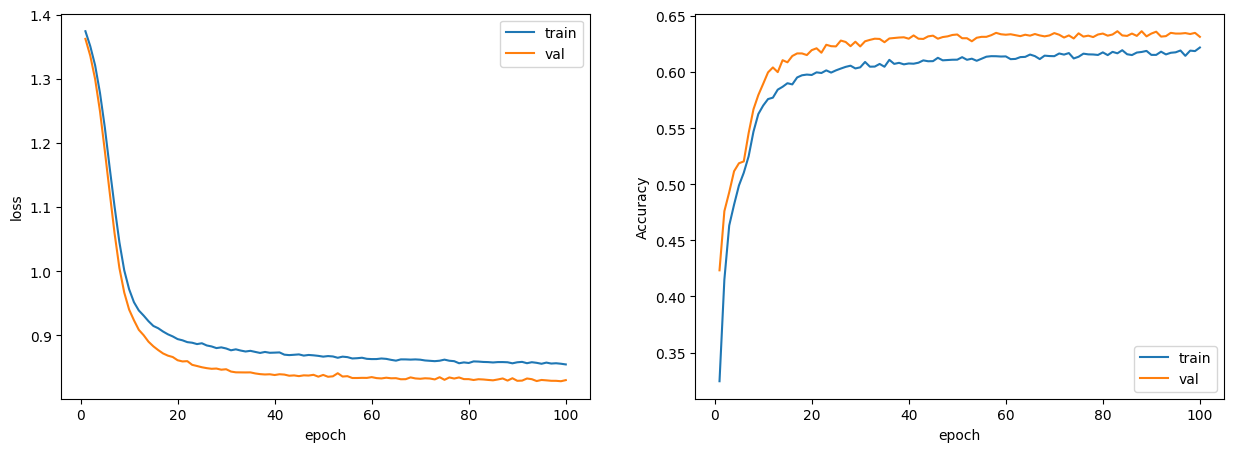

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
@torch.no_grad()
def predict(model, test_loader):
    model.eval()
    prediction = []

    for data, target in tqdm(test_loader, desc='Testing'):
        data = data.to(device)

        output = model(data)
        probabilities = torch.softmax(output, dim=1)
        prediction.append(probabilities)


    return prediction

In [ ]:
teset_dataset = TensorDataset(torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

test_loader = DataLoader(teset_dataset, batch_size=batch_size, shuffle=False)

preds = predict(model,test_loader)




Testing: 100%|██████████| 94/94 [00:00<00:00, 498.92it/s]


In [ ]:
conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()

In [ ]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")

Accuracy: 0.6258333333333334


In [ ]:
num_epochs = 60

batch_size = 64
dropout_prob = 0.55
hidden_size = 1024

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = None



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/60: 100%|██████████| 75/75 [00:00<00:00, 168.29it/s]


Epoch 1
 train loss: 1.0501945207516352, train acc: 0.51171875
 val loss: 0.8778979881604513, val acc: 0.6029166666666667



Validating epoch 2/60: 100%|██████████| 75/75 [00:00<00:00, 167.79it/s]


Epoch 2
 train loss: 0.92428573290507, train acc: 0.5778645873069763
 val loss: 0.8674599941571554, val acc: 0.605



Validating epoch 3/60: 100%|██████████| 75/75 [00:00<00:00, 153.20it/s]


Epoch 3
 train loss: 0.9024263616402944, train acc: 0.5882291793823242
 val loss: 0.849948783715566, val acc: 0.6197916666666666



Validating epoch 4/60: 100%|██████████| 75/75 [00:00<00:00, 163.56it/s]


Epoch 4
 train loss: 0.896240174372991, train acc: 0.5915625095367432
 val loss: 0.8542161711057027, val acc: 0.62375



Validating epoch 5/60: 100%|██████████| 75/75 [00:00<00:00, 169.66it/s]


Epoch 5
 train loss: 0.8843207609653473, train acc: 0.5983854532241821
 val loss: 0.8368950247764587, val acc: 0.6322916666666667



Validating epoch 6/60: 100%|██████████| 75/75 [00:00<00:00, 152.31it/s]


Epoch 6
 train loss: 0.8823604842027029, train acc: 0.6010416746139526
 val loss: 0.8558549642562866, val acc: 0.6166666666666667



Validating epoch 7/60: 100%|██████████| 75/75 [00:00<00:00, 155.73it/s]


Epoch 7
 train loss: 0.87884481549263, train acc: 0.604479193687439
 val loss: 0.8358833527565003, val acc: 0.6304166666666666



Validating epoch 8/60: 100%|██████████| 75/75 [00:00<00:00, 166.63it/s]


Epoch 8
 train loss: 0.8746996994813283, train acc: 0.6033333539962769
 val loss: 0.8644127464294433, val acc: 0.6175



Validating epoch 9/60: 100%|██████████| 75/75 [00:00<00:00, 169.02it/s]


Epoch 9
 train loss: 0.8716050032774607, train acc: 0.6058854460716248
 val loss: 0.8454613947868347, val acc: 0.62125



Validating epoch 10/60: 100%|██████████| 75/75 [00:00<00:00, 154.95it/s]


Epoch 10
 train loss: 0.8711481674512227, train acc: 0.6065624952316284
 val loss: 0.83297278881073, val acc: 0.6310416666666666



Validating epoch 11/60: 100%|██████████| 75/75 [00:00<00:00, 170.30it/s]


Epoch 11
 train loss: 0.8674308292071025, train acc: 0.6055208444595337
 val loss: 0.8319056526819865, val acc: 0.6325



Validating epoch 12/60: 100%|██████████| 75/75 [00:00<00:00, 168.11it/s]


Epoch 12
 train loss: 0.8695363940795263, train acc: 0.6084375381469727
 val loss: 0.8408529631296794, val acc: 0.62875



Validating epoch 13/60: 100%|██████████| 75/75 [00:00<00:00, 157.65it/s]


Epoch 13
 train loss: 0.8633975430329641, train acc: 0.6104687452316284
 val loss: 0.8320840605099996, val acc: 0.6302083333333334



Validating epoch 14/60: 100%|██████████| 75/75 [00:00<00:00, 169.01it/s]


Epoch 14
 train loss: 0.8651531688372294, train acc: 0.6093229055404663
 val loss: 0.836278669834137, val acc: 0.629375



Validating epoch 15/60: 100%|██████████| 75/75 [00:00<00:00, 168.07it/s]


Epoch 15
 train loss: 0.8619953272740046, train acc: 0.6116145849227905
 val loss: 0.8405739331245422, val acc: 0.6220833333333333



Validating epoch 16/60: 100%|██████████| 75/75 [00:00<00:00, 168.93it/s]


Epoch 16
 train loss: 0.8609174142281214, train acc: 0.6115104556083679
 val loss: 0.8272083338101704, val acc: 0.6327083333333333



Validating epoch 17/60: 100%|██████████| 75/75 [00:00<00:00, 153.44it/s]


Epoch 17
 train loss: 0.8575721857945124, train acc: 0.6143749952316284
 val loss: 0.8302760775883993, val acc: 0.630625



Validating epoch 18/60: 100%|██████████| 75/75 [00:00<00:00, 168.51it/s]


Epoch 18
 train loss: 0.8576170072952907, train acc: 0.6126562356948853
 val loss: 0.8259093395868937, val acc: 0.6329166666666667



Validating epoch 19/60: 100%|██████████| 75/75 [00:00<00:00, 167.34it/s]


Epoch 19
 train loss: 0.8582973291476568, train acc: 0.6130208373069763
 val loss: 0.8362496089935303, val acc: 0.6310416666666666



Validating epoch 20/60: 100%|██████████| 75/75 [00:00<00:00, 157.23it/s]


Epoch 20
 train loss: 0.853640022277832, train acc: 0.6148958206176758
 val loss: 0.8399257636070252, val acc: 0.6289583333333333



Validating epoch 21/60: 100%|██████████| 75/75 [00:00<00:00, 167.01it/s]


Epoch 21
 train loss: 0.8542029851675034, train acc: 0.6154687404632568
 val loss: 0.8308533310890198, val acc: 0.6302083333333334



Validating epoch 22/60: 100%|██████████| 75/75 [00:00<00:00, 167.01it/s]


Epoch 22
 train loss: 0.854866052865982, train acc: 0.6130208373069763
 val loss: 0.8269904327392578, val acc: 0.6322916666666667



Validating epoch 23/60: 100%|██████████| 75/75 [00:00<00:00, 153.78it/s]


Epoch 23
 train loss: 0.8518634436527888, train acc: 0.6164583563804626
 val loss: 0.8387933572133383, val acc: 0.6227083333333333



Validating epoch 24/60: 100%|██████████| 75/75 [00:00<00:00, 156.34it/s]


Epoch 24
 train loss: 0.8530481115976969, train acc: 0.6151562929153442
 val loss: 0.825725724697113, val acc: 0.63375



Validating epoch 25/60: 100%|██████████| 75/75 [00:00<00:00, 167.89it/s]


Epoch 25
 train loss: 0.8465630326668422, train acc: 0.6158854365348816
 val loss: 0.8228689082463583, val acc: 0.6360416666666666



Validating epoch 26/60: 100%|██████████| 75/75 [00:00<00:00, 169.17it/s]


Epoch 26
 train loss: 0.84541728079319, train acc: 0.6180729269981384
 val loss: 0.8216882507006328, val acc: 0.635625



Validating epoch 27/60: 100%|██████████| 75/75 [00:00<00:00, 152.94it/s]


Epoch 27
 train loss: 0.8452672888835271, train acc: 0.61677086353302
 val loss: 0.8302377676963806, val acc: 0.63125



Validating epoch 28/60: 100%|██████████| 75/75 [00:00<00:00, 168.57it/s]


Epoch 28
 train loss: 0.8471361857652664, train acc: 0.617968738079071
 val loss: 0.8249118908246358, val acc: 0.6304166666666666



Validating epoch 29/60: 100%|██████████| 75/75 [00:00<00:00, 167.97it/s]


Epoch 29
 train loss: 0.8448219138383866, train acc: 0.6193749904632568
 val loss: 0.8195136984189352, val acc: 0.6404166666666666



Validating epoch 30/60: 100%|██████████| 75/75 [00:00<00:00, 155.60it/s]


Epoch 30
 train loss: 0.8414501609404882, train acc: 0.6223958730697632
 val loss: 0.8277447891235351, val acc: 0.63



Validating epoch 31/60: 100%|██████████| 75/75 [00:00<00:00, 167.03it/s]


Epoch 31
 train loss: 0.8401805210113525, train acc: 0.6207292079925537
 val loss: 0.8230419564247131, val acc: 0.6366666666666667



Validating epoch 32/60: 100%|██████████| 75/75 [00:00<00:00, 166.30it/s]


Epoch 32
 train loss: 0.8406747070948283, train acc: 0.6176562905311584
 val loss: 0.8281065726280212, val acc: 0.6335416666666667



Validating epoch 33/60: 100%|██████████| 75/75 [00:00<00:00, 167.70it/s]


Epoch 33
 train loss: 0.8407397768894831, train acc: 0.6196874976158142
 val loss: 0.8317101740837097, val acc: 0.6260416666666667



Validating epoch 34/60: 100%|██████████| 75/75 [00:00<00:00, 156.43it/s]


Epoch 34
 train loss: 0.8388223814964294, train acc: 0.62088543176651
 val loss: 0.8215598662694296, val acc: 0.6383333333333333



Validating epoch 35/60: 100%|██████████| 75/75 [00:00<00:00, 168.59it/s]


Epoch 35
 train loss: 0.8383183815081914, train acc: 0.6201562881469727
 val loss: 0.8318274863560995, val acc: 0.6325



Validating epoch 36/60: 100%|██████████| 75/75 [00:00<00:00, 166.12it/s]


Epoch 36
 train loss: 0.8380133161942164, train acc: 0.6228646039962769
 val loss: 0.821731227238973, val acc: 0.6389583333333333



Validating epoch 37/60: 100%|██████████| 75/75 [00:00<00:00, 151.70it/s]


Epoch 37
 train loss: 0.8349384409189224, train acc: 0.6226041913032532
 val loss: 0.8241763806343079, val acc: 0.6335416666666667



Validating epoch 38/60: 100%|██████████| 75/75 [00:00<00:00, 168.75it/s]


Epoch 38
 train loss: 0.8342103807131449, train acc: 0.6247395873069763
 val loss: 0.828586908976237, val acc: 0.635



Validating epoch 39/60: 100%|██████████| 75/75 [00:00<00:00, 168.03it/s]


Epoch 39
 train loss: 0.8342657222350438, train acc: 0.6252083778381348
 val loss: 0.8262479662895202, val acc: 0.6329166666666667



Validating epoch 40/60: 100%|██████████| 75/75 [00:00<00:00, 165.54it/s]


Epoch 40
 train loss: 0.8335447108745575, train acc: 0.6209896206855774
 val loss: 0.8234129436810811, val acc: 0.6372916666666667



Validating epoch 41/60: 100%|██████████| 75/75 [00:00<00:00, 156.10it/s]


Epoch 41
 train loss: 0.831238736708959, train acc: 0.6276562809944153
 val loss: 0.8187462464968364, val acc: 0.636875



Validating epoch 42/60: 100%|██████████| 75/75 [00:00<00:00, 167.44it/s]


Epoch 42
 train loss: 0.8292769569158555, train acc: 0.6243229508399963
 val loss: 0.8255356311798095, val acc: 0.6329166666666667



Validating epoch 43/60: 100%|██████████| 75/75 [00:00<00:00, 167.24it/s]


Epoch 43
 train loss: 0.8300756371021271, train acc: 0.62890625
 val loss: 0.8212781723340352, val acc: 0.63875



Validating epoch 44/60: 100%|██████████| 75/75 [00:00<00:00, 155.53it/s]


Epoch 44
 train loss: 0.8286923752228419, train acc: 0.6279687881469727
 val loss: 0.8232226387659709, val acc: 0.6360416666666666



Validating epoch 45/60: 100%|██████████| 75/75 [00:00<00:00, 168.04it/s]


Epoch 45
 train loss: 0.8268766065438589, train acc: 0.62479168176651
 val loss: 0.8283405526479085, val acc: 0.6272916666666667



Validating epoch 46/60: 100%|██████████| 75/75 [00:00<00:00, 168.06it/s]


Epoch 46
 train loss: 0.8273161627848943, train acc: 0.6271874904632568
 val loss: 0.8261285694440206, val acc: 0.6327083333333333



Validating epoch 47/60: 100%|██████████| 75/75 [00:00<00:00, 155.94it/s]


Epoch 47
 train loss: 0.8251788115501404, train acc: 0.6263541579246521
 val loss: 0.8327329349517822, val acc: 0.62875



Validating epoch 48/60: 100%|██████████| 75/75 [00:00<00:00, 156.16it/s]


Epoch 48
 train loss: 0.825564036766688, train acc: 0.6301041841506958
 val loss: 0.8199089097976685, val acc: 0.6354166666666666



Validating epoch 49/60: 100%|██████████| 75/75 [00:00<00:00, 168.20it/s]


Epoch 49
 train loss: 0.8232306671142579, train acc: 0.6290625333786011
 val loss: 0.8303299315770467, val acc: 0.6320833333333333



Validating epoch 50/60: 100%|██████████| 75/75 [00:00<00:00, 167.44it/s]


Epoch 50
 train loss: 0.8234465126196543, train acc: 0.6312500238418579
 val loss: 0.832860910097758, val acc: 0.630625



Validating epoch 51/60: 100%|██████████| 75/75 [00:00<00:00, 155.33it/s]


Epoch 51
 train loss: 0.8199478191137314, train acc: 0.6311979293823242
 val loss: 0.8210041809082032, val acc: 0.640625



Validating epoch 52/60: 100%|██████████| 75/75 [00:00<00:00, 167.72it/s]


Epoch 52
 train loss: 0.8196788026889166, train acc: 0.6333333253860474
 val loss: 0.8210176197687785, val acc: 0.6347916666666666



Validating epoch 53/60: 100%|██████████| 75/75 [00:00<00:00, 167.33it/s]


Epoch 53
 train loss: 0.8231515125433604, train acc: 0.6299479603767395
 val loss: 0.8158947436014811, val acc: 0.641875



Validating epoch 54/60: 100%|██████████| 75/75 [00:00<00:00, 151.75it/s]


Epoch 54
 train loss: 0.8167883721987407, train acc: 0.6340104341506958
 val loss: 0.8281526525815328, val acc: 0.63375



Validating epoch 55/60: 100%|██████████| 75/75 [00:00<00:00, 164.19it/s]


Epoch 55
 train loss: 0.8187880955139796, train acc: 0.6284375190734863
 val loss: 0.8196559166908264, val acc: 0.6360416666666666



Validating epoch 56/60: 100%|██████████| 75/75 [00:00<00:00, 168.10it/s]


Epoch 56
 train loss: 0.8178490020831426, train acc: 0.6353645920753479
 val loss: 0.8208962472279867, val acc: 0.6402083333333334



Validating epoch 57/60: 100%|██████████| 75/75 [00:00<00:00, 167.18it/s]


Epoch 57
 train loss: 0.8160794222354889, train acc: 0.6328125
 val loss: 0.8193570399284362, val acc: 0.640625



Validating epoch 58/60: 100%|██████████| 75/75 [00:00<00:00, 152.92it/s]


Epoch 58
 train loss: 0.8153315530220667, train acc: 0.6365625262260437
 val loss: 0.8236587500572204, val acc: 0.6354166666666666



Validating epoch 59/60: 100%|██████████| 75/75 [00:00<00:00, 168.11it/s]


Epoch 59
 train loss: 0.8143208696444829, train acc: 0.6344791650772095
 val loss: 0.8227001484235128, val acc: 0.6389583333333333



Validating epoch 60/60: 100%|██████████| 75/75 [00:00<00:00, 167.34it/s]

Epoch 60
 train loss: 0.8125636619329453, train acc: 0.6372395753860474
 val loss: 0.821038818359375, val acc: 0.639375



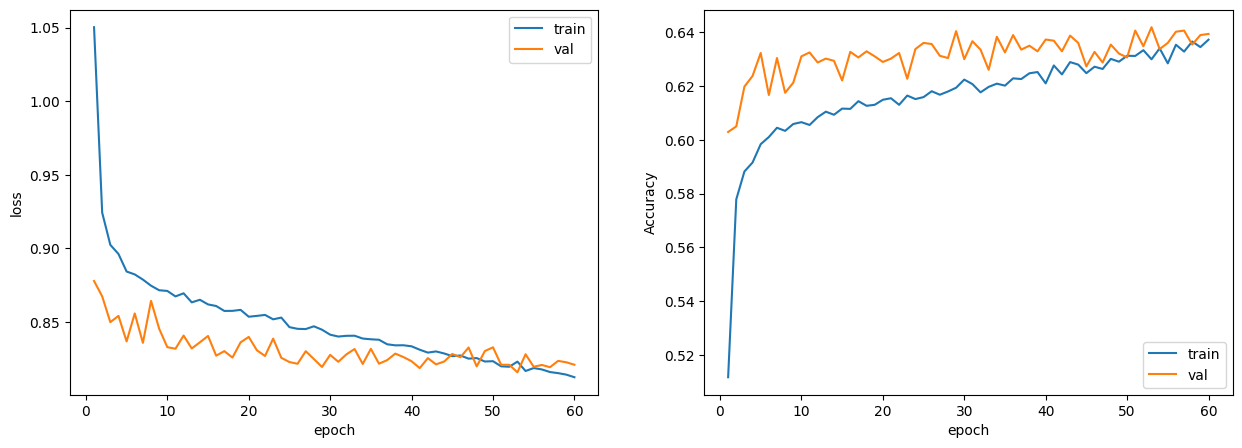

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
teset_dataset = TensorDataset(torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

test_loader = DataLoader(teset_dataset, batch_size=batch_size, shuffle=False)

preds = predict(model,test_loader)




Testing: 100%|██████████| 94/94 [00:00<00:00, 193.16it/s]


In [ ]:
conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")

Accuracy: 0.6325


In [ ]:
num_epochs = 50

batch_size = 64
dropout_prob = 0.5
hidden_size = 128

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/50: 100%|██████████| 75/75 [00:00<00:00, 518.05it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.033306561112404, train acc: 0.5278125405311584
 val loss: 0.876938214302063, val acc: 0.6183333333333333



Validating epoch 2/50: 100%|██████████| 75/75 [00:00<00:00, 349.01it/s]


Epoch 2
 train loss: 0.9236908920605977, train acc: 0.57833331823349
 val loss: 0.853109495639801, val acc: 0.619375



Validating epoch 3/50: 100%|██████████| 75/75 [00:00<00:00, 352.93it/s]


Epoch 3
 train loss: 0.911026941537857, train acc: 0.5889583230018616
 val loss: 0.8781978869438172, val acc: 0.6014583333333333



Validating epoch 4/50: 100%|██████████| 75/75 [00:00<00:00, 539.00it/s]


Epoch 4
 train loss: 0.8980776170889536, train acc: 0.59765625
 val loss: 0.8484358660380046, val acc: 0.6185416666666667



Validating epoch 5/50: 100%|██████████| 75/75 [00:00<00:00, 540.82it/s]


Epoch 5
 train loss: 0.8913497485717138, train acc: 0.5956250429153442
 val loss: 0.8498843804995219, val acc: 0.6172916666666667



Validating epoch 6/50: 100%|██████████| 75/75 [00:00<00:00, 484.08it/s]


Epoch 6
 train loss: 0.8880717738469441, train acc: 0.5990104079246521
 val loss: 0.8394202764829, val acc: 0.6254166666666666



Validating epoch 7/50: 100%|██████████| 75/75 [00:00<00:00, 358.42it/s]


Epoch 7
 train loss: 0.8827716018756231, train acc: 0.6035416722297668
 val loss: 0.8402591029802958, val acc: 0.6275



Validating epoch 8/50: 100%|██████████| 75/75 [00:00<00:00, 382.61it/s]


Epoch 8
 train loss: 0.881451820731163, train acc: 0.5998437404632568
 val loss: 0.8396063860257467, val acc: 0.6264583333333333



Validating epoch 9/50: 100%|██████████| 75/75 [00:00<00:00, 394.03it/s]


Epoch 9
 train loss: 0.8774993379910787, train acc: 0.5986458659172058
 val loss: 0.853965163230896, val acc: 0.6225



Validating epoch 10/50: 100%|██████████| 75/75 [00:00<00:00, 485.15it/s]


Epoch 10
 train loss: 0.8701047406593958, train acc: 0.6088541746139526
 val loss: 0.841623199780782, val acc: 0.6283333333333333



Validating epoch 11/50: 100%|██████████| 75/75 [00:00<00:00, 359.20it/s]


Epoch 11
 train loss: 0.870805082321167, train acc: 0.6112500429153442
 val loss: 0.8491549181938172, val acc: 0.62125



Validating epoch 12/50: 100%|██████████| 75/75 [00:00<00:00, 354.75it/s]


Epoch 12
 train loss: 0.8703457456827164, train acc: 0.60916668176651
 val loss: 0.8351003487904867, val acc: 0.6277083333333333



Validating epoch 13/50: 100%|██████████| 75/75 [00:00<00:00, 509.09it/s]


Epoch 13
 train loss: 0.8662961961825689, train acc: 0.6092708706855774
 val loss: 0.8359855914115906, val acc: 0.630625



Validating epoch 14/50: 100%|██████████| 75/75 [00:00<00:00, 513.47it/s]


Epoch 14
 train loss: 0.862088328798612, train acc: 0.6114062666893005
 val loss: 0.8409692366917928, val acc: 0.6260416666666667



Validating epoch 15/50: 100%|██████████| 75/75 [00:00<00:00, 505.56it/s]


Epoch 15
 train loss: 0.86127022087574, train acc: 0.6103125214576721
 val loss: 0.8328564222653707, val acc: 0.63125



Validating epoch 16/50: 100%|██████████| 75/75 [00:00<00:00, 498.74it/s]


Epoch 16
 train loss: 0.8598406366507212, train acc: 0.61307293176651
 val loss: 0.8307640679677327, val acc: 0.6327083333333333



Validating epoch 17/50: 100%|██████████| 75/75 [00:00<00:00, 490.32it/s]


Epoch 17
 train loss: 0.8574762574831645, train acc: 0.6133333444595337
 val loss: 0.8242882212003072, val acc: 0.6375



Validating epoch 18/50: 100%|██████████| 75/75 [00:00<00:00, 549.38it/s]


Epoch 18
 train loss: 0.8573910266160965, train acc: 0.616406261920929
 val loss: 0.8257491286595663, val acc: 0.6385416666666667



Validating epoch 19/50: 100%|██████████| 75/75 [00:00<00:00, 509.23it/s]


Epoch 19
 train loss: 0.8552133836348852, train acc: 0.6146354079246521
 val loss: 0.8272581585248311, val acc: 0.63125



Validating epoch 20/50: 100%|██████████| 75/75 [00:00<00:00, 333.78it/s]


Epoch 20
 train loss: 0.8516951461633047, train acc: 0.6180729269981384
 val loss: 0.8268492515881857, val acc: 0.625625



Validating epoch 21/50: 100%|██████████| 75/75 [00:00<00:00, 358.62it/s]


Epoch 21
 train loss: 0.853275585770607, train acc: 0.616197943687439
 val loss: 0.8362203470865885, val acc: 0.6291666666666667



Validating epoch 22/50: 100%|██████████| 75/75 [00:00<00:00, 348.50it/s]


Epoch 22
 train loss: 0.8518326950073242, train acc: 0.61677086353302
 val loss: 0.8221847915649414, val acc: 0.6377083333333333



Validating epoch 23/50: 100%|██████████| 75/75 [00:00<00:00, 537.42it/s]


Epoch 23
 train loss: 0.8478605357805887, train acc: 0.6235416531562805
 val loss: 0.8271853001912435, val acc: 0.6341666666666667



Validating epoch 24/50: 100%|██████████| 75/75 [00:00<00:00, 536.66it/s]


Epoch 24
 train loss: 0.8463656395673752, train acc: 0.6194270849227905
 val loss: 0.8315627606709798, val acc: 0.6239583333333333



Validating epoch 25/50: 100%|██████████| 75/75 [00:00<00:00, 511.85it/s]


Epoch 25
 train loss: 0.8473924944798151, train acc: 0.62067711353302
 val loss: 0.8332971827189127, val acc: 0.6275



Validating epoch 26/50: 100%|██████████| 75/75 [00:00<00:00, 506.58it/s]


Epoch 26
 train loss: 0.846903283794721, train acc: 0.6171354055404663
 val loss: 0.8223741738001505, val acc: 0.6372916666666667



Validating epoch 27/50: 100%|██████████| 75/75 [00:00<00:00, 513.87it/s]


Epoch 27
 train loss: 0.8407763328154881, train acc: 0.6193229556083679
 val loss: 0.8275026353200277, val acc: 0.6358333333333334



Validating epoch 28/50: 100%|██████████| 75/75 [00:00<00:00, 506.37it/s]


Epoch 28
 train loss: 0.8420177841186524, train acc: 0.6250520944595337
 val loss: 0.8225732119878133, val acc: 0.635625



Validating epoch 29/50: 100%|██████████| 75/75 [00:00<00:00, 497.81it/s]


Epoch 29
 train loss: 0.8407551584641139, train acc: 0.6217708587646484
 val loss: 0.8216948382059733, val acc: 0.6345833333333334



Validating epoch 30/50: 100%|██████████| 75/75 [00:00<00:00, 335.83it/s]


Epoch 30
 train loss: 0.8384071187178294, train acc: 0.6239062547683716
 val loss: 0.826671166419983, val acc: 0.6320833333333333



Validating epoch 31/50: 100%|██████████| 75/75 [00:00<00:00, 354.40it/s]


Epoch 31
 train loss: 0.8375627579291661, train acc: 0.6277604103088379
 val loss: 0.8276846305529276, val acc: 0.6335416666666667



Validating epoch 32/50: 100%|██████████| 75/75 [00:00<00:00, 539.99it/s]


Epoch 32
 train loss: 0.8379138298829396, train acc: 0.6242708563804626
 val loss: 0.8239953962961832, val acc: 0.6314583333333333



Validating epoch 33/50: 100%|██████████| 75/75 [00:00<00:00, 553.77it/s]


Epoch 33
 train loss: 0.8350056417783102, train acc: 0.6226041913032532
 val loss: 0.8190974736213684, val acc: 0.6370833333333333



Validating epoch 34/50: 100%|██████████| 75/75 [00:00<00:00, 506.39it/s]


Epoch 34
 train loss: 0.8345202900966009, train acc: 0.6256250143051147
 val loss: 0.8203770748774211, val acc: 0.6391666666666667



Validating epoch 35/50: 100%|██████████| 75/75 [00:00<00:00, 495.04it/s]


Epoch 35
 train loss: 0.8324939105908076, train acc: 0.619895875453949
 val loss: 0.8236867086092631, val acc: 0.636875



Validating epoch 36/50: 100%|██████████| 75/75 [00:00<00:00, 497.28it/s]


Epoch 36
 train loss: 0.8359520924091339, train acc: 0.6232812404632568
 val loss: 0.8233058698972067, val acc: 0.635625



Validating epoch 37/50: 100%|██████████| 75/75 [00:00<00:00, 505.43it/s]


Epoch 37
 train loss: 0.8283946182330449, train acc: 0.6282812356948853
 val loss: 0.826570676167806, val acc: 0.6339583333333333



Validating epoch 38/50: 100%|██████████| 75/75 [00:00<00:00, 512.92it/s]


Epoch 38
 train loss: 0.8340692269802094, train acc: 0.6240625381469727
 val loss: 0.8273556566238404, val acc: 0.633125



Validating epoch 39/50: 100%|██████████| 75/75 [00:00<00:00, 358.45it/s]


Epoch 39
 train loss: 0.8276923501491547, train acc: 0.62848961353302
 val loss: 0.8305532463391622, val acc: 0.6314583333333333



Validating epoch 40/50: 100%|██████████| 75/75 [00:00<00:00, 346.33it/s]


Epoch 40
 train loss: 0.828238292336464, train acc: 0.62869793176651
 val loss: 0.8227259914080302, val acc: 0.6310416666666666



Validating epoch 41/50: 100%|██████████| 75/75 [00:00<00:00, 345.60it/s]


Epoch 41
 train loss: 0.8279868217309316, train acc: 0.6283854246139526
 val loss: 0.8239494379361471, val acc: 0.6379166666666667



Validating epoch 42/50: 100%|██████████| 75/75 [00:00<00:00, 495.81it/s]


Epoch 42
 train loss: 0.8292920164267222, train acc: 0.6269270777702332
 val loss: 0.8287874547640482, val acc: 0.6335416666666667



Validating epoch 43/50: 100%|██████████| 75/75 [00:00<00:00, 504.39it/s]


Epoch 43
 train loss: 0.8284880032142004, train acc: 0.6290104389190674
 val loss: 0.8292783125241597, val acc: 0.628125



Validating epoch 44/50: 100%|██████████| 75/75 [00:00<00:00, 505.94it/s]


Epoch 44
 train loss: 0.8255630048116048, train acc: 0.631614625453949
 val loss: 0.8385065348943075, val acc: 0.6310416666666666



Validating epoch 45/50: 100%|██████████| 75/75 [00:00<00:00, 526.40it/s]


Epoch 45
 train loss: 0.8213629778226217, train acc: 0.6327083706855774
 val loss: 0.8341623799006144, val acc: 0.6272916666666667



Validating epoch 46/50: 100%|██████████| 75/75 [00:00<00:00, 507.23it/s]


Epoch 46
 train loss: 0.8236404585838318, train acc: 0.6277604103088379
 val loss: 0.8226739994684855, val acc: 0.6364583333333333



Validating epoch 47/50: 100%|██████████| 75/75 [00:00<00:00, 473.74it/s]


Epoch 47
 train loss: 0.8267530874411265, train acc: 0.6258333325386047
 val loss: 0.8224386580785116, val acc: 0.6345833333333334



Validating epoch 48/50: 100%|██████████| 75/75 [00:00<00:00, 516.90it/s]


Epoch 48
 train loss: 0.8204611597458521, train acc: 0.6354687809944153
 val loss: 0.8378792945543925, val acc: 0.6279166666666667



Validating epoch 49/50: 100%|██████████| 75/75 [00:00<00:00, 380.80it/s]


Epoch 49
 train loss: 0.8207736718654632, train acc: 0.6366146206855774
 val loss: 0.8283733797073364, val acc: 0.6341666666666667



Validating epoch 50/50: 100%|██████████| 75/75 [00:00<00:00, 367.78it/s]

Epoch 50
 train loss: 0.8177808167537054, train acc: 0.6339062452316284
 val loss: 0.8244452842076619, val acc: 0.6320833333333333



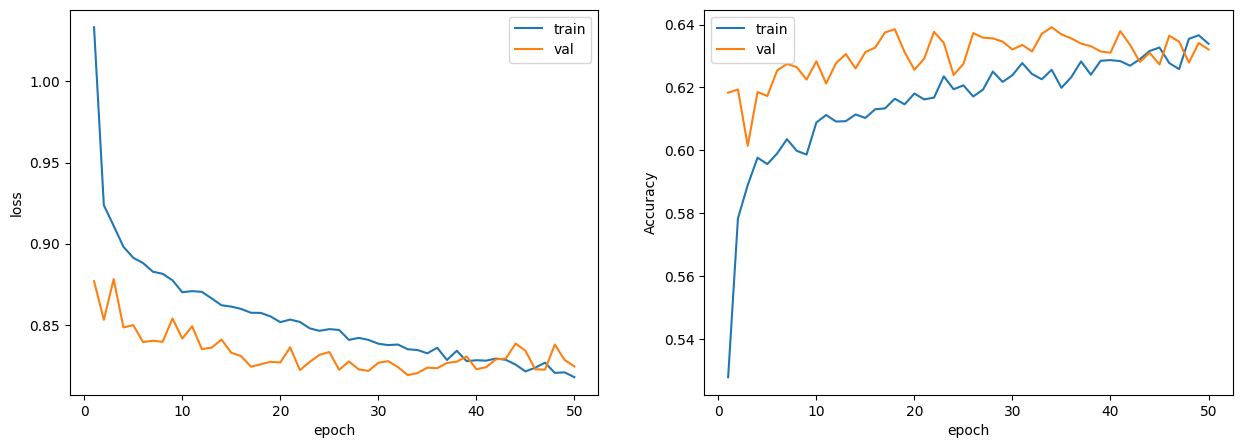

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)

In [ ]:

preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 94/94 [00:00<00:00, 372.71it/s]


In [ ]:
acc_step = accuracy_score(y_test, res)
print(f"Accuracy: {acc_step}")

Accuracy: 0.6403333333333333


In [ ]:
num_epochs = 40

batch_size = 64
dropout_prob = 0.5
hidden_size = 128

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/40: 100%|██████████| 75/75 [00:00<00:00, 208.61it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.0377579226096472, train acc: 0.5207291841506958
 val loss: 0.882876451810201, val acc: 0.6083333333333333



Validating epoch 2/40: 100%|██████████| 75/75 [00:00<00:00, 429.45it/s]


Epoch 2
 train loss: 0.9266421935955683, train acc: 0.5824479460716248
 val loss: 0.8559709088007609, val acc: 0.614375



Validating epoch 3/40: 100%|██████████| 75/75 [00:00<00:00, 528.15it/s]


Epoch 3
 train loss: 0.9107394083340963, train acc: 0.5924479365348816
 val loss: 0.8574690175056457, val acc: 0.631875



Validating epoch 4/40: 100%|██████████| 75/75 [00:00<00:00, 522.37it/s]


Epoch 4
 train loss: 0.9053983412186305, train acc: 0.5916146039962769
 val loss: 0.8405849289894104, val acc: 0.6233333333333333



Validating epoch 5/40: 100%|██████████| 75/75 [00:00<00:00, 531.84it/s]


Epoch 5
 train loss: 0.8926766594250997, train acc: 0.5977083444595337
 val loss: 0.8420197645823161, val acc: 0.6254166666666666



Validating epoch 6/40: 100%|██████████| 75/75 [00:00<00:00, 499.94it/s]


Epoch 6
 train loss: 0.8923706207672755, train acc: 0.5939062833786011
 val loss: 0.8549911371866862, val acc: 0.6202083333333334



Validating epoch 7/40: 100%|██████████| 75/75 [00:00<00:00, 514.02it/s]


Epoch 7
 train loss: 0.8826225280761719, train acc: 0.6000000238418579
 val loss: 0.8424056609471638, val acc: 0.6272916666666667



Validating epoch 8/40: 100%|██████████| 75/75 [00:00<00:00, 540.20it/s]


Epoch 8
 train loss: 0.8776003980636596, train acc: 0.6056250333786011
 val loss: 0.8510941537221273, val acc: 0.6189583333333334



Validating epoch 9/40: 100%|██████████| 75/75 [00:00<00:00, 314.47it/s]


Epoch 9
 train loss: 0.8727144567171733, train acc: 0.6024479269981384
 val loss: 0.8392237003644307, val acc: 0.6316666666666667



Validating epoch 10/40: 100%|██████████| 75/75 [00:00<00:00, 351.01it/s]


Epoch 10
 train loss: 0.8708061454693476, train acc: 0.6091145873069763
 val loss: 0.8331384547551473, val acc: 0.6316666666666667



Validating epoch 11/40: 100%|██████████| 75/75 [00:00<00:00, 354.95it/s]


Epoch 11
 train loss: 0.8722876791159312, train acc: 0.6092708706855774
 val loss: 0.8303068153063456, val acc: 0.6345833333333334



Validating epoch 12/40: 100%|██████████| 75/75 [00:00<00:00, 497.67it/s]


Epoch 12
 train loss: 0.8681273168325424, train acc: 0.6101042032241821
 val loss: 0.8435252022743225, val acc: 0.6272916666666667



Validating epoch 13/40: 100%|██████████| 75/75 [00:00<00:00, 507.83it/s]


Epoch 13
 train loss: 0.8666538403431574, train acc: 0.6070312857627869
 val loss: 0.8366144386927287, val acc: 0.6354166666666666



Validating epoch 14/40: 100%|██████████| 75/75 [00:00<00:00, 472.11it/s]


Epoch 14
 train loss: 0.8657638253768285, train acc: 0.612291693687439
 val loss: 0.8367183089256287, val acc: 0.6320833333333333



Validating epoch 15/40: 100%|██████████| 75/75 [00:00<00:00, 500.94it/s]


Epoch 15
 train loss: 0.8630217764774958, train acc: 0.6109895706176758
 val loss: 0.8428939612706502, val acc: 0.62375



Validating epoch 16/40: 100%|██████████| 75/75 [00:00<00:00, 511.29it/s]


Epoch 16
 train loss: 0.8615172300736109, train acc: 0.6120312809944153
 val loss: 0.836427059173584, val acc: 0.6285416666666667



Validating epoch 17/40: 100%|██████████| 75/75 [00:00<00:00, 502.34it/s]


Epoch 17
 train loss: 0.8610157831509908, train acc: 0.6107812523841858
 val loss: 0.8289720575014751, val acc: 0.6339583333333333



Validating epoch 18/40: 100%|██████████| 75/75 [00:00<00:00, 512.19it/s]


Epoch 18
 train loss: 0.860530211130778, train acc: 0.6128125190734863
 val loss: 0.8414960138003031, val acc: 0.61875



Validating epoch 19/40: 100%|██████████| 75/75 [00:00<00:00, 362.38it/s]


Epoch 19
 train loss: 0.8580652670065562, train acc: 0.6126562356948853
 val loss: 0.8359942563374837, val acc: 0.6345833333333334



Validating epoch 20/40: 100%|██████████| 75/75 [00:00<00:00, 354.15it/s]


Epoch 20
 train loss: 0.8535493705670039, train acc: 0.6140104532241821
 val loss: 0.8259554704030355, val acc: 0.633125



Validating epoch 21/40: 100%|██████████| 75/75 [00:00<00:00, 473.95it/s]


Epoch 21
 train loss: 0.8551800070206325, train acc: 0.6146354079246521
 val loss: 0.8252862373987834, val acc: 0.6347916666666666



Validating epoch 22/40: 100%|██████████| 75/75 [00:00<00:00, 504.82it/s]


Epoch 22
 train loss: 0.8515730679035187, train acc: 0.6192187666893005
 val loss: 0.83247962474823, val acc: 0.6204166666666666



Validating epoch 23/40: 100%|██████████| 75/75 [00:00<00:00, 517.94it/s]


Epoch 23
 train loss: 0.8515812800327937, train acc: 0.617760419845581
 val loss: 0.8287559533119202, val acc: 0.636875



Validating epoch 24/40: 100%|██████████| 75/75 [00:00<00:00, 493.74it/s]


Epoch 24
 train loss: 0.8463229644298553, train acc: 0.6184375286102295
 val loss: 0.8228732307751974, val acc: 0.63625



Validating epoch 25/40: 100%|██████████| 75/75 [00:00<00:00, 483.00it/s]


Epoch 25
 train loss: 0.8452704505125681, train acc: 0.620520830154419
 val loss: 0.8224179323514302, val acc: 0.6377083333333333



Validating epoch 26/40: 100%|██████████| 75/75 [00:00<00:00, 496.12it/s]


Epoch 26
 train loss: 0.8463731626669566, train acc: 0.6168749928474426
 val loss: 0.8289226810137431, val acc: 0.6329166666666667



Validating epoch 27/40: 100%|██████████| 75/75 [00:00<00:00, 515.74it/s]


Epoch 27
 train loss: 0.8442495115598043, train acc: 0.6180208325386047
 val loss: 0.8357102576891581, val acc: 0.6329166666666667



Validating epoch 28/40: 100%|██████████| 75/75 [00:00<00:00, 333.76it/s]


Epoch 28
 train loss: 0.8471278168757757, train acc: 0.6223958730697632
 val loss: 0.8263586012522379, val acc: 0.6354166666666666



Validating epoch 29/40: 100%|██████████| 75/75 [00:00<00:00, 348.14it/s]


Epoch 29
 train loss: 0.8455667847394943, train acc: 0.620312511920929
 val loss: 0.8360616914431254, val acc: 0.625625



Validating epoch 30/40: 100%|██████████| 75/75 [00:00<00:00, 328.51it/s]


Epoch 30
 train loss: 0.8403280248244603, train acc: 0.6213021278381348
 val loss: 0.8288967355092367, val acc: 0.630625



Validating epoch 31/40: 100%|██████████| 75/75 [00:00<00:00, 514.64it/s]


Epoch 31
 train loss: 0.8410449620087942, train acc: 0.6220833659172058
 val loss: 0.8302291377385458, val acc: 0.6316666666666667



Validating epoch 32/40: 100%|██████████| 75/75 [00:00<00:00, 495.95it/s]


Epoch 32
 train loss: 0.8372475701570511, train acc: 0.6216145753860474
 val loss: 0.8239246948560079, val acc: 0.6295833333333334



Validating epoch 33/40: 100%|██████████| 75/75 [00:00<00:00, 479.13it/s]


Epoch 33
 train loss: 0.8392566992839178, train acc: 0.6249479055404663
 val loss: 0.8250837238629659, val acc: 0.6279166666666667



Validating epoch 34/40: 100%|██████████| 75/75 [00:00<00:00, 503.93it/s]


Epoch 34
 train loss: 0.8379521826903026, train acc: 0.624218761920929
 val loss: 0.8340799355506897, val acc: 0.6310416666666666



Validating epoch 35/40: 100%|██████████| 75/75 [00:00<00:00, 499.22it/s]


Epoch 35
 train loss: 0.8322208680709203, train acc: 0.6258854269981384
 val loss: 0.8310648806889852, val acc: 0.6314583333333333



Validating epoch 36/40: 100%|██████████| 75/75 [00:00<00:00, 516.32it/s]


Epoch 36
 train loss: 0.8346727506319682, train acc: 0.6272395849227905
 val loss: 0.8304835255940756, val acc: 0.6327083333333333



Validating epoch 37/40: 100%|██████████| 75/75 [00:00<00:00, 302.02it/s]


Epoch 37
 train loss: 0.8325880193710327, train acc: 0.6276562809944153
 val loss: 0.8321645951271057, val acc: 0.630625



Validating epoch 38/40: 100%|██████████| 75/75 [00:00<00:00, 351.06it/s]


Epoch 38
 train loss: 0.8297194844484329, train acc: 0.6263021230697632
 val loss: 0.8266274801890056, val acc: 0.6322916666666667



Validating epoch 39/40: 100%|██████████| 75/75 [00:00<00:00, 322.45it/s]


Epoch 39
 train loss: 0.8281440287828445, train acc: 0.6290625333786011
 val loss: 0.8233825222651163, val acc: 0.63875



Validating epoch 40/40: 100%|██████████| 75/75 [00:00<00:00, 272.64it/s]

Epoch 40
 train loss: 0.8287634601195654, train acc: 0.624427080154419
 val loss: 0.8258194414774577, val acc: 0.6389583333333333



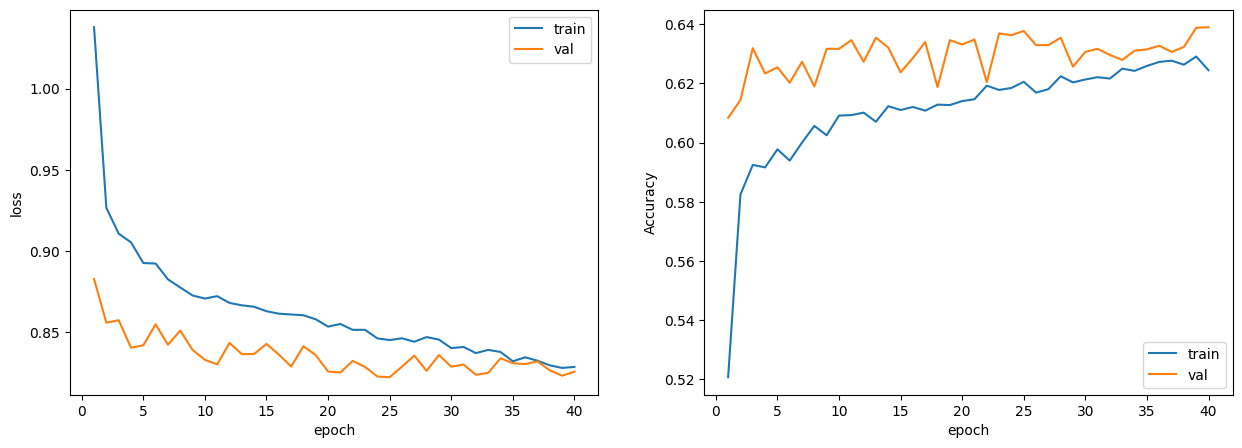

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)

In [ ]:

preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 94/94 [00:00<00:00, 544.59it/s]


In [ ]:
acc_step2 = accuracy_score(y_test, res)
print(f"Accuracy: {acc_step2}")

Accuracy: 0.641


In [ ]:
num_epochs = 70

batch_size = 64
dropout_prob = 0.5
hidden_size = 128

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/70: 100%|██████████| 75/75 [00:00<00:00, 164.85it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.0345808527867, train acc: 0.5241667032241821
 val loss: 0.8907545646031697, val acc: 0.603125



Validating epoch 2/70: 100%|██████████| 75/75 [00:00<00:00, 514.29it/s]


Epoch 2
 train loss: 0.9412824465831121, train acc: 0.5746875405311584
 val loss: 0.8654938991864523, val acc: 0.6179166666666667



Validating epoch 3/70: 100%|██████████| 75/75 [00:00<00:00, 466.26it/s]


Epoch 3
 train loss: 0.9238602024316788, train acc: 0.581041693687439
 val loss: 0.8653048276901245, val acc: 0.6064583333333333



Validating epoch 4/70: 100%|██████████| 75/75 [00:00<00:00, 350.92it/s]


Epoch 4
 train loss: 0.9148113226890564, train acc: 0.5834895968437195
 val loss: 0.8630018965403239, val acc: 0.6122916666666667



Validating epoch 5/70: 100%|██████████| 75/75 [00:00<00:00, 353.17it/s]


Epoch 5
 train loss: 0.9122871009508768, train acc: 0.5878645777702332
 val loss: 0.8554121955235799, val acc: 0.6204166666666666



Validating epoch 6/70: 100%|██████████| 75/75 [00:00<00:00, 327.39it/s]


Epoch 6
 train loss: 0.903156016667684, train acc: 0.5893750190734863
 val loss: 0.8777264285087586, val acc: 0.6066666666666667



Validating epoch 7/70: 100%|██████████| 75/75 [00:00<00:00, 507.00it/s]


Epoch 7
 train loss: 0.8944501175483068, train acc: 0.5944792032241821
 val loss: 0.8378917773564657, val acc: 0.629375



Validating epoch 8/70: 100%|██████████| 75/75 [00:00<00:00, 479.09it/s]


Epoch 8
 train loss: 0.8976979478200277, train acc: 0.5908854603767395
 val loss: 0.8444722175598145, val acc: 0.6227083333333333



Validating epoch 9/70: 100%|██████████| 75/75 [00:00<00:00, 500.10it/s]


Epoch 9
 train loss: 0.8909557894865672, train acc: 0.5987499952316284
 val loss: 0.8390896256764729, val acc: 0.6214583333333333



Validating epoch 10/70: 100%|██████████| 75/75 [00:00<00:00, 450.04it/s]


Epoch 10
 train loss: 0.8892940469582875, train acc: 0.5985416769981384
 val loss: 0.8374337212244669, val acc: 0.6270833333333333



Validating epoch 11/70: 100%|██████████| 75/75 [00:00<00:00, 507.41it/s]


Epoch 11
 train loss: 0.8849272414048512, train acc: 0.6026042103767395
 val loss: 0.8281115396817526, val acc: 0.6322916666666667



Validating epoch 12/70: 100%|██████████| 75/75 [00:00<00:00, 493.30it/s]


Epoch 12
 train loss: 0.8843059118588765, train acc: 0.6001562476158142
 val loss: 0.8467143845558166, val acc: 0.6239583333333333



Validating epoch 13/70: 100%|██████████| 75/75 [00:00<00:00, 499.74it/s]


Epoch 13
 train loss: 0.8856376860539118, train acc: 0.59723961353302
 val loss: 0.8724146676063538, val acc: 0.6158333333333333



Validating epoch 14/70: 100%|██████████| 75/75 [00:00<00:00, 330.94it/s]


Epoch 14
 train loss: 0.8813729093472162, train acc: 0.6000000238418579
 val loss: 0.8385075664520264, val acc: 0.62625



Validating epoch 15/70: 100%|██████████| 75/75 [00:00<00:00, 332.68it/s]


Epoch 15
 train loss: 0.878170783718427, train acc: 0.6008333563804626
 val loss: 0.8470884839693705, val acc: 0.616875



Validating epoch 16/70: 100%|██████████| 75/75 [00:00<00:00, 506.65it/s]


Epoch 16
 train loss: 0.874820206562678, train acc: 0.6030208468437195
 val loss: 0.8608561197916667, val acc: 0.6225



Validating epoch 17/70: 100%|██████████| 75/75 [00:00<00:00, 475.50it/s]


Epoch 17
 train loss: 0.8739940891663234, train acc: 0.6107291579246521
 val loss: 0.8321605483690898, val acc: 0.6264583333333333



Validating epoch 18/70: 100%|██████████| 75/75 [00:00<00:00, 513.54it/s]


Epoch 18
 train loss: 0.8702437156438827, train acc: 0.608802080154419
 val loss: 0.8370306022961934, val acc: 0.629375



Validating epoch 19/70: 100%|██████████| 75/75 [00:00<00:00, 486.74it/s]


Epoch 19
 train loss: 0.8711033731698989, train acc: 0.6069270968437195
 val loss: 0.8587297097841898, val acc: 0.6185416666666667



Validating epoch 20/70: 100%|██████████| 75/75 [00:00<00:00, 510.52it/s]


Epoch 20
 train loss: 0.8713194334506988, train acc: 0.6069791913032532
 val loss: 0.8335605112711588, val acc: 0.625625



Validating epoch 21/70: 100%|██████████| 75/75 [00:00<00:00, 495.89it/s]


Epoch 21
 train loss: 0.8706518600384394, train acc: 0.6080729365348816
 val loss: 0.8231207593282064, val acc: 0.6345833333333334



Validating epoch 22/70: 100%|██████████| 75/75 [00:00<00:00, 490.93it/s]


Epoch 22
 train loss: 0.8719004730383555, train acc: 0.6052083373069763
 val loss: 0.8484777776400249, val acc: 0.6216666666666667



Validating epoch 23/70: 100%|██████████| 75/75 [00:00<00:00, 327.43it/s]


Epoch 23
 train loss: 0.867252508799235, train acc: 0.6085416674613953
 val loss: 0.8405433551470438, val acc: 0.6172916666666667



Validating epoch 24/70: 100%|██████████| 75/75 [00:00<00:00, 364.94it/s]


Epoch 24
 train loss: 0.8624686028560002, train acc: 0.6098958253860474
 val loss: 0.8460152196884155, val acc: 0.6195833333333334



Validating epoch 25/70: 100%|██████████| 75/75 [00:00<00:00, 341.65it/s]


Epoch 25
 train loss: 0.8705102330446244, train acc: 0.6066666841506958
 val loss: 0.8333675527572632, val acc: 0.629375



Validating epoch 26/70: 100%|██████████| 75/75 [00:00<00:00, 506.27it/s]


Epoch 26
 train loss: 0.8648955241839091, train acc: 0.6058333516120911
 val loss: 0.8400474699338277, val acc: 0.63



Validating epoch 27/70: 100%|██████████| 75/75 [00:00<00:00, 516.03it/s]


Epoch 27
 train loss: 0.8660765943924585, train acc: 0.6089062690734863
 val loss: 0.8330292304356893, val acc: 0.6289583333333333



Validating epoch 28/70: 100%|██████████| 75/75 [00:00<00:00, 484.94it/s]


Epoch 28
 train loss: 0.8617134690284729, train acc: 0.6123437881469727
 val loss: 0.8407161784172058, val acc: 0.6202083333333334



Validating epoch 29/70: 100%|██████████| 75/75 [00:00<00:00, 479.90it/s]


Epoch 29
 train loss: 0.8618595172961553, train acc: 0.6082812547683716
 val loss: 0.8391585421562194, val acc: 0.62375



Validating epoch 30/70: 100%|██████████| 75/75 [00:00<00:00, 506.40it/s]


Epoch 30
 train loss: 0.8651923791567484, train acc: 0.6075000166893005
 val loss: 0.8464941612879435, val acc: 0.6191666666666666



Validating epoch 31/70: 100%|██████████| 75/75 [00:00<00:00, 514.18it/s]


Epoch 31
 train loss: 0.8620245675245921, train acc: 0.6092187762260437
 val loss: 0.8263345487912496, val acc: 0.6335416666666667



Validating epoch 32/70: 100%|██████████| 75/75 [00:00<00:00, 388.28it/s]


Epoch 32
 train loss: 0.8625314585367838, train acc: 0.61328125
 val loss: 0.8333242758115132, val acc: 0.6347916666666666



Validating epoch 33/70: 100%|██████████| 75/75 [00:00<00:00, 326.87it/s]


Epoch 33
 train loss: 0.8619158093134562, train acc: 0.6102083325386047
 val loss: 0.8399890303611756, val acc: 0.63



Validating epoch 34/70: 100%|██████████| 75/75 [00:00<00:00, 337.84it/s]


Epoch 34
 train loss: 0.8560294630130132, train acc: 0.6116145849227905
 val loss: 0.8261300055185954, val acc: 0.6364583333333333



Validating epoch 35/70: 100%|██████████| 75/75 [00:00<00:00, 484.11it/s]


Epoch 35
 train loss: 0.8543529675404231, train acc: 0.6148437857627869
 val loss: 0.8492913699150085, val acc: 0.624375



Validating epoch 36/70: 100%|██████████| 75/75 [00:00<00:00, 514.14it/s]


Epoch 36
 train loss: 0.8549598894516627, train acc: 0.6118749976158142
 val loss: 0.845471727848053, val acc: 0.62375



Validating epoch 37/70: 100%|██████████| 75/75 [00:00<00:00, 499.76it/s]


Epoch 37
 train loss: 0.8528069460391998, train acc: 0.6123437881469727
 val loss: 0.8277650292714437, val acc: 0.6366666666666667



Validating epoch 38/70: 100%|██████████| 75/75 [00:00<00:00, 497.24it/s]


Epoch 38
 train loss: 0.8456890334685644, train acc: 0.6171354055404663
 val loss: 0.8262039605776469, val acc: 0.633125



Validating epoch 39/70: 100%|██████████| 75/75 [00:00<00:00, 522.02it/s]


Epoch 39
 train loss: 0.8461634049812953, train acc: 0.6175000071525574
 val loss: 0.8241354370117188, val acc: 0.6372916666666667



Validating epoch 40/70: 100%|██████████| 75/75 [00:00<00:00, 475.03it/s]


Epoch 40
 train loss: 0.8475107439359029, train acc: 0.6181250214576721
 val loss: 0.8435014041264852, val acc: 0.6195833333333334



Validating epoch 41/70: 100%|██████████| 75/75 [00:00<00:00, 508.70it/s]


Epoch 41
 train loss: 0.8477389874060949, train acc: 0.6186979413032532
 val loss: 0.8518580818176269, val acc: 0.6285416666666667



Validating epoch 42/70: 100%|██████████| 75/75 [00:00<00:00, 339.92it/s]


Epoch 42
 train loss: 0.8479332840442657, train acc: 0.6168229579925537
 val loss: 0.8302622000376384, val acc: 0.629375



Validating epoch 43/70: 100%|██████████| 75/75 [00:00<00:00, 323.29it/s]


Epoch 43
 train loss: 0.8500493594010671, train acc: 0.6145312786102295
 val loss: 0.8419225891431172, val acc: 0.6283333333333333



Validating epoch 44/70: 100%|██████████| 75/75 [00:00<00:00, 512.52it/s]


Epoch 44
 train loss: 0.8418386848767598, train acc: 0.6187500357627869
 val loss: 0.8253401811917623, val acc: 0.6375



Validating epoch 45/70: 100%|██████████| 75/75 [00:00<00:00, 526.85it/s]


Epoch 45
 train loss: 0.8454905329147975, train acc: 0.6197395920753479
 val loss: 0.8430440378189087, val acc: 0.619375



Validating epoch 46/70: 100%|██████████| 75/75 [00:00<00:00, 485.36it/s]


Epoch 46
 train loss: 0.8473769241571426, train acc: 0.6162500381469727
 val loss: 0.8352587795257569, val acc: 0.631875



Validating epoch 47/70: 100%|██████████| 75/75 [00:00<00:00, 516.75it/s]


Epoch 47
 train loss: 0.8446385935942332, train acc: 0.6180729269981384
 val loss: 0.8317659529050191, val acc: 0.6314583333333333



Validating epoch 48/70: 100%|██████████| 75/75 [00:00<00:00, 491.77it/s]


Epoch 48
 train loss: 0.842783583799998, train acc: 0.619895875453949
 val loss: 0.8361091828346252, val acc: 0.6252083333333334



Validating epoch 49/70: 100%|██████████| 75/75 [00:00<00:00, 471.90it/s]


Epoch 49
 train loss: 0.844893830815951, train acc: 0.6172395944595337
 val loss: 0.826979378859202, val acc: 0.6347916666666666



Validating epoch 50/70: 100%|██████████| 75/75 [00:00<00:00, 514.10it/s]


Epoch 50
 train loss: 0.8427315833171208, train acc: 0.6194270849227905
 val loss: 0.8323338238398234, val acc: 0.6270833333333333



Validating epoch 51/70: 100%|██████████| 75/75 [00:00<00:00, 337.27it/s]


Epoch 51
 train loss: 0.8421090950568517, train acc: 0.6225000023841858
 val loss: 0.8296338844299317, val acc: 0.6314583333333333



Validating epoch 52/70: 100%|██████████| 75/75 [00:00<00:00, 346.34it/s]


Epoch 52
 train loss: 0.8402833247184753, train acc: 0.625
 val loss: 0.8337161540985107, val acc: 0.625625



Validating epoch 53/70: 100%|██████████| 75/75 [00:00<00:00, 326.77it/s]


Epoch 53
 train loss: 0.8392782255013784, train acc: 0.6215625405311584
 val loss: 0.8319357744852702, val acc: 0.636875



Validating epoch 54/70: 100%|██████████| 75/75 [00:00<00:00, 464.67it/s]


Epoch 54
 train loss: 0.8362003779411316, train acc: 0.6246354579925537
 val loss: 0.831959863503774, val acc: 0.629375



Validating epoch 55/70: 100%|██████████| 75/75 [00:00<00:00, 474.70it/s]


Epoch 55
 train loss: 0.8365775986512503, train acc: 0.6261979341506958
 val loss: 0.8363735087712606, val acc: 0.6258333333333334



Validating epoch 56/70: 100%|██████████| 75/75 [00:00<00:00, 486.23it/s]


Epoch 56
 train loss: 0.8397178123394649, train acc: 0.6211458444595337
 val loss: 0.8449413545926412, val acc: 0.6272916666666667



Validating epoch 57/70: 100%|██████████| 75/75 [00:00<00:00, 465.94it/s]


Epoch 57
 train loss: 0.8360432728131613, train acc: 0.6217708587646484
 val loss: 0.8309640622138977, val acc: 0.6360416666666666



Validating epoch 58/70: 100%|██████████| 75/75 [00:00<00:00, 447.95it/s]


Epoch 58
 train loss: 0.8292396934827169, train acc: 0.6240625381469727
 val loss: 0.8437818280855814, val acc: 0.6247916666666666



Validating epoch 59/70: 100%|██████████| 75/75 [00:00<00:00, 509.78it/s]


Epoch 59
 train loss: 0.835235624909401, train acc: 0.6276562809944153
 val loss: 0.8310178065299988, val acc: 0.625625



Validating epoch 60/70: 100%|██████████| 75/75 [00:00<00:00, 499.94it/s]


Epoch 60
 train loss: 0.8378639703989029, train acc: 0.6178125143051147
 val loss: 0.8326827955245971, val acc: 0.6308333333333334



Validating epoch 61/70: 100%|██████████| 75/75 [00:00<00:00, 370.95it/s]


Epoch 61
 train loss: 0.833589916229248, train acc: 0.6236458420753479
 val loss: 0.8335402194658915, val acc: 0.6329166666666667



Validating epoch 62/70: 100%|██████████| 75/75 [00:00<00:00, 351.08it/s]


Epoch 62
 train loss: 0.8260293259223302, train acc: 0.6251562833786011
 val loss: 0.8470235935846965, val acc: 0.6247916666666666



Validating epoch 63/70: 100%|██████████| 75/75 [00:00<00:00, 502.23it/s]


Epoch 63
 train loss: 0.8282338686784109, train acc: 0.6266145706176758
 val loss: 0.843379422823588, val acc: 0.6314583333333333



Validating epoch 64/70: 100%|██████████| 75/75 [00:00<00:00, 489.22it/s]


Epoch 64
 train loss: 0.8265257877111435, train acc: 0.6308854222297668
 val loss: 0.8363020976384481, val acc: 0.624375



Validating epoch 65/70: 100%|██████████| 75/75 [00:00<00:00, 521.83it/s]


Epoch 65
 train loss: 0.8280086231231689, train acc: 0.6271874904632568
 val loss: 0.8340219664573669, val acc: 0.6297916666666666



Validating epoch 66/70: 100%|██████████| 75/75 [00:00<00:00, 503.61it/s]


Epoch 66
 train loss: 0.8273960206906, train acc: 0.6278125047683716
 val loss: 0.842112041314443, val acc: 0.630625



Validating epoch 67/70: 100%|██████████| 75/75 [00:00<00:00, 472.09it/s]


Epoch 67
 train loss: 0.8249135740598043, train acc: 0.6282812356948853
 val loss: 0.8342125082015991, val acc: 0.635



Validating epoch 68/70: 100%|██████████| 75/75 [00:00<00:00, 486.31it/s]


Epoch 68
 train loss: 0.8250764515002569, train acc: 0.6296354532241821
 val loss: 0.8359950494766235, val acc: 0.629375



Validating epoch 69/70: 100%|██████████| 75/75 [00:00<00:00, 491.20it/s]


Epoch 69
 train loss: 0.8245215781529744, train acc: 0.6271354556083679
 val loss: 0.8364457559585571, val acc: 0.6277083333333333



Validating epoch 70/70: 100%|██████████| 75/75 [00:00<00:00, 351.23it/s]

Epoch 70
 train loss: 0.8264407954613368, train acc: 0.6232292056083679
 val loss: 0.830039668083191, val acc: 0.6279166666666667



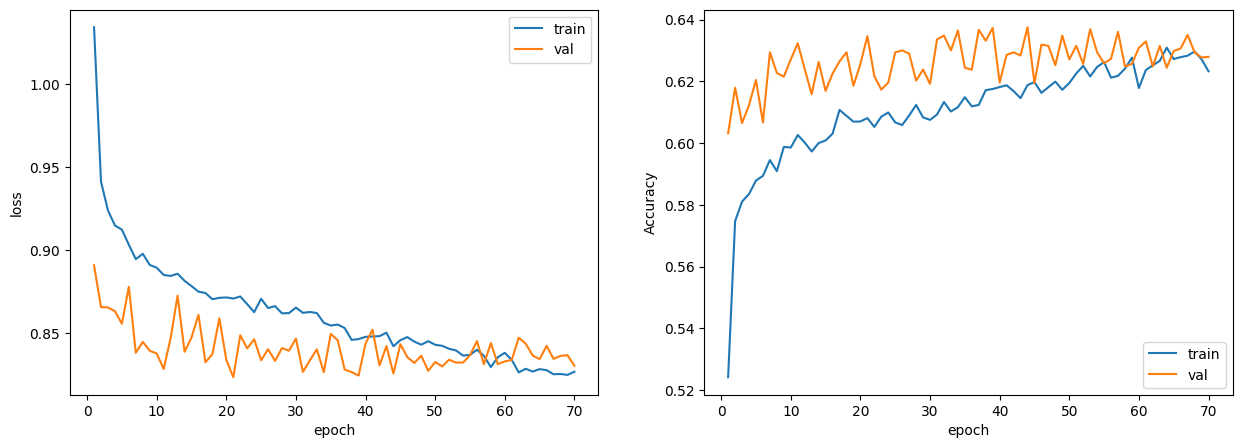

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)

In [ ]:

preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 94/94 [00:00<00:00, 582.95it/s]


In [ ]:
acc_step3 = accuracy_score(y_test, res)
print(f"Accuracy: {acc_step3}")

Accuracy: 0.6331666666666667


In [ ]:
num_epochs = 40

batch_size = 64
dropout_prob = 0.3
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/40: 100%|██████████| 75/75 [00:00<00:00, 490.29it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.0089069813489915, train acc: 0.5258333683013916
 val loss: 0.8777258070309957, val acc: 0.595625



Validating epoch 2/40: 100%|██████████| 75/75 [00:00<00:00, 490.92it/s]


Epoch 2
 train loss: 0.8986431401968002, train acc: 0.5942187905311584
 val loss: 0.8443849078814188, val acc: 0.6308333333333334



Validating epoch 3/40: 100%|██████████| 75/75 [00:00<00:00, 472.19it/s]


Epoch 3
 train loss: 0.889488565325737, train acc: 0.5964062809944153
 val loss: 0.9065638399124145, val acc: 0.5966666666666667



Validating epoch 4/40: 100%|██████████| 75/75 [00:00<00:00, 509.41it/s]


Epoch 4
 train loss: 0.8792911507685979, train acc: 0.6008854508399963
 val loss: 0.8730797338485717, val acc: 0.6095833333333334



Validating epoch 5/40: 100%|██████████| 75/75 [00:00<00:00, 495.62it/s]


Epoch 5
 train loss: 0.8731538343429566, train acc: 0.6036458611488342
 val loss: 0.8370735088984171, val acc: 0.6308333333333334



Validating epoch 6/40: 100%|██████████| 75/75 [00:00<00:00, 522.06it/s]


Epoch 6
 train loss: 0.8712123354276021, train acc: 0.6059895753860474
 val loss: 0.8392472815513611, val acc: 0.6227083333333333



Validating epoch 7/40: 100%|██████████| 75/75 [00:00<00:00, 330.40it/s]


Epoch 7
 train loss: 0.8689162504673004, train acc: 0.6092187762260437
 val loss: 0.8400716344515483, val acc: 0.6208333333333333



Validating epoch 8/40: 100%|██████████| 75/75 [00:00<00:00, 313.95it/s]


Epoch 8
 train loss: 0.8645829194784165, train acc: 0.612708330154419
 val loss: 0.8361806702613831, val acc: 0.6329166666666667



Validating epoch 9/40: 100%|██████████| 75/75 [00:00<00:00, 491.39it/s]


Epoch 9
 train loss: 0.8624948394298554, train acc: 0.6148437857627869
 val loss: 0.8309368562698364, val acc: 0.6277083333333333



Validating epoch 10/40: 100%|██████████| 75/75 [00:00<00:00, 515.25it/s]


Epoch 10
 train loss: 0.860954532623291, train acc: 0.6118229031562805
 val loss: 0.8490192802747091, val acc: 0.6214583333333333



Validating epoch 11/40: 100%|██████████| 75/75 [00:00<00:00, 526.18it/s]


Epoch 11
 train loss: 0.8608575568596522, train acc: 0.608593761920929
 val loss: 0.8374704559644063, val acc: 0.6310416666666666



Validating epoch 12/40: 100%|██████████| 75/75 [00:00<00:00, 528.67it/s]


Epoch 12
 train loss: 0.8576184296607972, train acc: 0.6129167079925537
 val loss: 0.8256192636489869, val acc: 0.6360416666666666



Validating epoch 13/40: 100%|██████████| 75/75 [00:00<00:00, 516.46it/s]


Epoch 13
 train loss: 0.8533552012840907, train acc: 0.6128125190734863
 val loss: 0.8323495332400004, val acc: 0.6360416666666666



Validating epoch 14/40: 100%|██████████| 75/75 [00:00<00:00, 534.21it/s]


Epoch 14
 train loss: 0.8542929810285568, train acc: 0.6145833730697632
 val loss: 0.8350701689720154, val acc: 0.6233333333333333



Validating epoch 15/40: 100%|██████████| 75/75 [00:00<00:00, 499.37it/s]


Epoch 15
 train loss: 0.8501889989773432, train acc: 0.6177083253860474
 val loss: 0.8301273266474406, val acc: 0.6310416666666666



Validating epoch 16/40: 100%|██████████| 75/75 [00:00<00:00, 341.76it/s]


Epoch 16
 train loss: 0.8498167328039805, train acc: 0.6226041913032532
 val loss: 0.8298522130648295, val acc: 0.6302083333333334



Validating epoch 17/40: 100%|██████████| 75/75 [00:00<00:00, 330.70it/s]


Epoch 17
 train loss: 0.8470191925764083, train acc: 0.6183854341506958
 val loss: 0.8239703090985616, val acc: 0.6354166666666666



Validating epoch 18/40: 100%|██████████| 75/75 [00:00<00:00, 518.83it/s]


Epoch 18
 train loss: 0.8474085674683253, train acc: 0.6189583539962769
 val loss: 0.8277107373873392, val acc: 0.6314583333333333



Validating epoch 19/40: 100%|██████████| 75/75 [00:00<00:00, 531.87it/s]


Epoch 19
 train loss: 0.8430063670873642, train acc: 0.6222395896911621
 val loss: 0.8235195239384969, val acc: 0.6377083333333333



Validating epoch 20/40: 100%|██████████| 75/75 [00:00<00:00, 508.88it/s]


Epoch 20
 train loss: 0.8441678806145986, train acc: 0.6213541626930237
 val loss: 0.8247363909085592, val acc: 0.6370833333333333



Validating epoch 21/40: 100%|██████████| 75/75 [00:00<00:00, 449.28it/s]


Epoch 21
 train loss: 0.8430791385968526, train acc: 0.6192708611488342
 val loss: 0.835690302848816, val acc: 0.630625



Validating epoch 22/40: 100%|██████████| 75/75 [00:00<00:00, 504.10it/s]


Epoch 22
 train loss: 0.8416461990276972, train acc: 0.6230729222297668
 val loss: 0.8325812474886576, val acc: 0.628125



Validating epoch 23/40: 100%|██████████| 75/75 [00:00<00:00, 533.99it/s]


Epoch 23
 train loss: 0.838925477663676, train acc: 0.6229687929153442
 val loss: 0.8187709776560466, val acc: 0.63875



Validating epoch 24/40: 100%|██████████| 75/75 [00:00<00:00, 507.17it/s]


Epoch 24
 train loss: 0.8370580669244131, train acc: 0.6242708563804626
 val loss: 0.8250634781519572, val acc: 0.6297916666666666



Validating epoch 25/40: 100%|██████████| 75/75 [00:00<00:00, 343.37it/s]


Epoch 25
 train loss: 0.835443802078565, train acc: 0.6229687929153442
 val loss: 0.8331292136510213, val acc: 0.6275



Validating epoch 26/40: 100%|██████████| 75/75 [00:00<00:00, 331.92it/s]


Epoch 26
 train loss: 0.8364419591426849, train acc: 0.621666669845581
 val loss: 0.8246334139506022, val acc: 0.6360416666666666



Validating epoch 27/40: 100%|██████████| 75/75 [00:00<00:00, 499.57it/s]


Epoch 27
 train loss: 0.8331138706207275, train acc: 0.6240625381469727
 val loss: 0.8241924111048381, val acc: 0.63875



Validating epoch 28/40: 100%|██████████| 75/75 [00:00<00:00, 517.50it/s]


Epoch 28
 train loss: 0.8319016041358313, train acc: 0.6218229532241821
 val loss: 0.8184122943878174, val acc: 0.6402083333333334



Validating epoch 29/40: 100%|██████████| 75/75 [00:00<00:00, 521.71it/s]


Epoch 29
 train loss: 0.8300800728797912, train acc: 0.6239583492279053
 val loss: 0.8224210627873738, val acc: 0.6385416666666667



Validating epoch 30/40: 100%|██████████| 75/75 [00:00<00:00, 511.16it/s]


Epoch 30
 train loss: 0.831807504693667, train acc: 0.6236458420753479
 val loss: 0.8232149235407511, val acc: 0.64



Validating epoch 31/40: 100%|██████████| 75/75 [00:00<00:00, 503.80it/s]


Epoch 31
 train loss: 0.8269650375843048, train acc: 0.6297395825386047
 val loss: 0.8197607064247131, val acc: 0.635



Validating epoch 32/40: 100%|██████████| 75/75 [00:00<00:00, 496.12it/s]


Epoch 32
 train loss: 0.8238399245341619, train acc: 0.6299999952316284
 val loss: 0.8299772071838379, val acc: 0.6352083333333334



Validating epoch 33/40: 100%|██████████| 75/75 [00:00<00:00, 430.69it/s]


Epoch 33
 train loss: 0.8246991552909215, train acc: 0.6293229460716248
 val loss: 0.8169059522946676, val acc: 0.6397916666666666



Validating epoch 34/40: 100%|██████████| 75/75 [00:00<00:00, 354.56it/s]


Epoch 34
 train loss: 0.823351689974467, train acc: 0.6299479603767395
 val loss: 0.8247764301300049, val acc: 0.6360416666666666



Validating epoch 35/40: 100%|██████████| 75/75 [00:00<00:00, 327.13it/s]


Epoch 35
 train loss: 0.8207618472973506, train acc: 0.6302604079246521
 val loss: 0.8331655351320902, val acc: 0.633125



Validating epoch 36/40: 100%|██████████| 75/75 [00:00<00:00, 506.92it/s]


Epoch 36
 train loss: 0.8225336515903473, train acc: 0.6297916769981384
 val loss: 0.8250141898790996, val acc: 0.6402083333333334



Validating epoch 37/40: 100%|██████████| 75/75 [00:00<00:00, 519.91it/s]


Epoch 37
 train loss: 0.8189487381776174, train acc: 0.6332291960716248
 val loss: 0.8184278813997904, val acc: 0.6427083333333333



Validating epoch 38/40: 100%|██████████| 75/75 [00:00<00:00, 492.79it/s]


Epoch 38
 train loss: 0.8169008886814118, train acc: 0.6342708468437195
 val loss: 0.8217669216791789, val acc: 0.636875



Validating epoch 39/40: 100%|██████████| 75/75 [00:00<00:00, 484.95it/s]


Epoch 39
 train loss: 0.8187320895989736, train acc: 0.6331771016120911
 val loss: 0.8196877606709798, val acc: 0.639375



Validating epoch 40/40: 100%|██████████| 75/75 [00:00<00:00, 502.00it/s]

Epoch 40
 train loss: 0.8167105495929718, train acc: 0.6344791650772095
 val loss: 0.8212397893269857, val acc: 0.635625



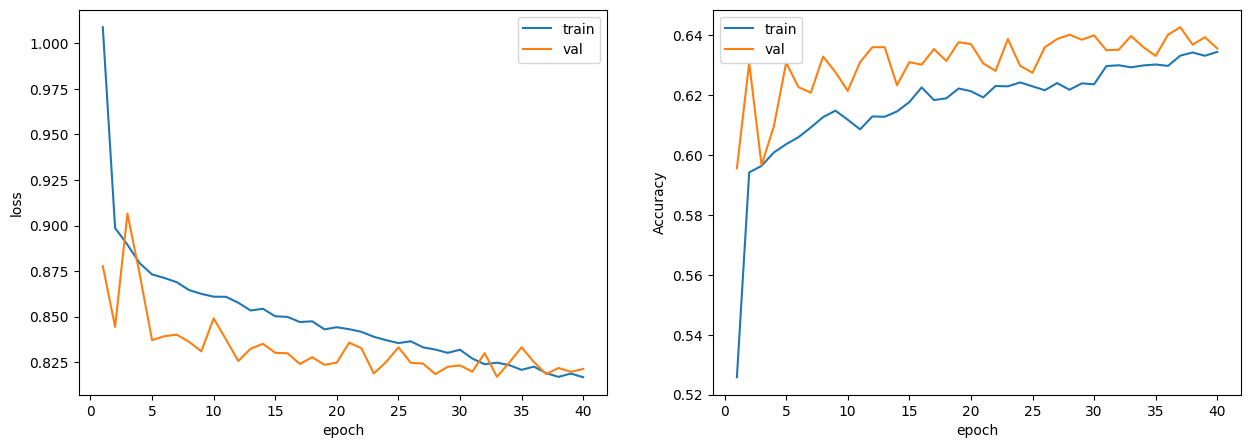

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)
plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:

preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 94/94 [00:00<00:00, 532.77it/s]


In [ ]:
acc_labbdalr = accuracy_score(y_test, res)
print(f"Accuracy: {acc_labbdalr}")

Accuracy: 0.634


In [ ]:
num_epochs = 30

batch_size = 64
dropout_prob = 0.3
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
lambda1 = lambda epoch: 0.6 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/30: 100%|██████████| 75/75 [00:00<00:00, 506.52it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.0303776158889135, train acc: 0.51583331823349
 val loss: 0.8600323390960694, val acc: 0.616875



Validating epoch 2/30: 100%|██████████| 75/75 [00:00<00:00, 360.89it/s]


Epoch 2
 train loss: 0.8987809542814891, train acc: 0.5912500023841858
 val loss: 0.8525984358787536, val acc: 0.623125



Validating epoch 3/30: 100%|██████████| 75/75 [00:00<00:00, 350.89it/s]


Epoch 3
 train loss: 0.8883279252052307, train acc: 0.5981770753860474
 val loss: 0.8666798090934753, val acc: 0.6154166666666666



Validating epoch 4/30: 100%|██████████| 75/75 [00:00<00:00, 521.63it/s]


Epoch 4
 train loss: 0.8792970416943232, train acc: 0.6034375429153442
 val loss: 0.8467006413141887, val acc: 0.6170833333333333



Validating epoch 5/30: 100%|██████████| 75/75 [00:00<00:00, 540.02it/s]


Epoch 5
 train loss: 0.8793805758158366, train acc: 0.604687511920929
 val loss: 0.839825518131256, val acc: 0.6345833333333334



Validating epoch 6/30: 100%|██████████| 75/75 [00:00<00:00, 548.01it/s]


Epoch 6
 train loss: 0.8722977834939957, train acc: 0.6030729413032532
 val loss: 0.8513529102007548, val acc: 0.6214583333333333



Validating epoch 7/30: 100%|██████████| 75/75 [00:00<00:00, 535.18it/s]


Epoch 7
 train loss: 0.8717820094029108, train acc: 0.6082291603088379
 val loss: 0.8431967806816101, val acc: 0.6275



Validating epoch 8/30: 100%|██████████| 75/75 [00:00<00:00, 526.24it/s]


Epoch 8
 train loss: 0.8705442909399669, train acc: 0.6067708730697632
 val loss: 0.834681753317515, val acc: 0.6316666666666667



Validating epoch 9/30: 100%|██████████| 75/75 [00:00<00:00, 545.20it/s]


Epoch 9
 train loss: 0.8667417814334234, train acc: 0.6067187786102295
 val loss: 0.8396540403366088, val acc: 0.6327083333333333



Validating epoch 10/30: 100%|██████████| 75/75 [00:00<00:00, 494.40it/s]


Epoch 10
 train loss: 0.8679521878560384, train acc: 0.6096875071525574
 val loss: 0.8496258926391601, val acc: 0.6202083333333334



Validating epoch 11/30: 100%|██████████| 75/75 [00:00<00:00, 321.16it/s]


Epoch 11
 train loss: 0.8632354730367661, train acc: 0.6092708706855774
 val loss: 0.8350479578971863, val acc: 0.633125



Validating epoch 12/30: 100%|██████████| 75/75 [00:00<00:00, 335.76it/s]


Epoch 12
 train loss: 0.8608755228916803, train acc: 0.6113541722297668
 val loss: 0.858284322420756, val acc: 0.61625



Validating epoch 13/30: 100%|██████████| 75/75 [00:00<00:00, 514.78it/s]


Epoch 13
 train loss: 0.8608766287565232, train acc: 0.6113020777702332
 val loss: 0.830563264687856, val acc: 0.6308333333333334



Validating epoch 14/30: 100%|██████████| 75/75 [00:00<00:00, 508.72it/s]


Epoch 14
 train loss: 0.8601938821872075, train acc: 0.6122395992279053
 val loss: 0.8338295499483744, val acc: 0.62875



Validating epoch 15/30: 100%|██████████| 75/75 [00:00<00:00, 533.51it/s]


Epoch 15
 train loss: 0.8570617075761159, train acc: 0.6146875023841858
 val loss: 0.8420954656600952, val acc: 0.6266666666666667



Validating epoch 16/30: 100%|██████████| 75/75 [00:00<00:00, 534.70it/s]


Epoch 16
 train loss: 0.8577111864089966, train acc: 0.6133854389190674
 val loss: 0.8358699194590251, val acc: 0.63375



Validating epoch 17/30: 100%|██████████| 75/75 [00:00<00:00, 512.60it/s]


Epoch 17
 train loss: 0.8580992052952449, train acc: 0.6151562929153442
 val loss: 0.843583398660024, val acc: 0.6285416666666667



Validating epoch 18/30: 100%|██████████| 75/75 [00:00<00:00, 509.90it/s]


Epoch 18
 train loss: 0.8544971625010173, train acc: 0.6170833706855774
 val loss: 0.8257175437609354, val acc: 0.635



Validating epoch 19/30: 100%|██████████| 75/75 [00:00<00:00, 529.27it/s]


Epoch 19
 train loss: 0.8542831053336462, train acc: 0.6141666769981384
 val loss: 0.8334093793233236, val acc: 0.6335416666666667



Validating epoch 20/30: 100%|██████████| 75/75 [00:00<00:00, 382.28it/s]


Epoch 20
 train loss: 0.8531128929058711, train acc: 0.616614580154419
 val loss: 0.8251671202977499, val acc: 0.6366666666666667



Validating epoch 21/30: 100%|██████████| 75/75 [00:00<00:00, 337.04it/s]


Epoch 21
 train loss: 0.8535296487808227, train acc: 0.6175000071525574
 val loss: 0.8266064953804017, val acc: 0.6347916666666666



Validating epoch 22/30: 100%|██████████| 75/75 [00:00<00:00, 526.77it/s]


Epoch 22
 train loss: 0.8500951661666234, train acc: 0.6178125143051147
 val loss: 0.8256902901331583, val acc: 0.6358333333333334



Validating epoch 23/30: 100%|██████████| 75/75 [00:00<00:00, 515.72it/s]


Epoch 23
 train loss: 0.8516816625992457, train acc: 0.6156771183013916
 val loss: 0.8271733752886454, val acc: 0.635



Validating epoch 24/30: 100%|██████████| 75/75 [00:00<00:00, 517.05it/s]


Epoch 24
 train loss: 0.8499818738301596, train acc: 0.6157812476158142
 val loss: 0.838848926226298, val acc: 0.6264583333333333



Validating epoch 25/30: 100%|██████████| 75/75 [00:00<00:00, 519.84it/s]


Epoch 25
 train loss: 0.8484207834800085, train acc: 0.6189062595367432
 val loss: 0.8276271708806355, val acc: 0.6341666666666667



Validating epoch 26/30: 100%|██████████| 75/75 [00:00<00:00, 517.10it/s]


Epoch 26
 train loss: 0.8496532541513443, train acc: 0.6188020706176758
 val loss: 0.8236885404586792, val acc: 0.63625



Validating epoch 27/30: 100%|██████████| 75/75 [00:00<00:00, 527.33it/s]


Epoch 27
 train loss: 0.8470065180460612, train acc: 0.6163020730018616
 val loss: 0.8230436436335246, val acc: 0.6354166666666666



Validating epoch 28/30: 100%|██████████| 75/75 [00:00<00:00, 387.87it/s]


Epoch 28
 train loss: 0.8465763717889786, train acc: 0.6173437833786011
 val loss: 0.8278876503308614, val acc: 0.6325



Validating epoch 29/30: 100%|██████████| 75/75 [00:00<00:00, 339.33it/s]


Epoch 29
 train loss: 0.8453454585870107, train acc: 0.6230208277702332
 val loss: 0.8311050033569336, val acc: 0.6341666666666667



Validating epoch 30/30: 100%|██████████| 75/75 [00:00<00:00, 360.86it/s]

Epoch 30
 train loss: 0.8451453495025635, train acc: 0.617760419845581
 val loss: 0.8283712490399678, val acc: 0.634375



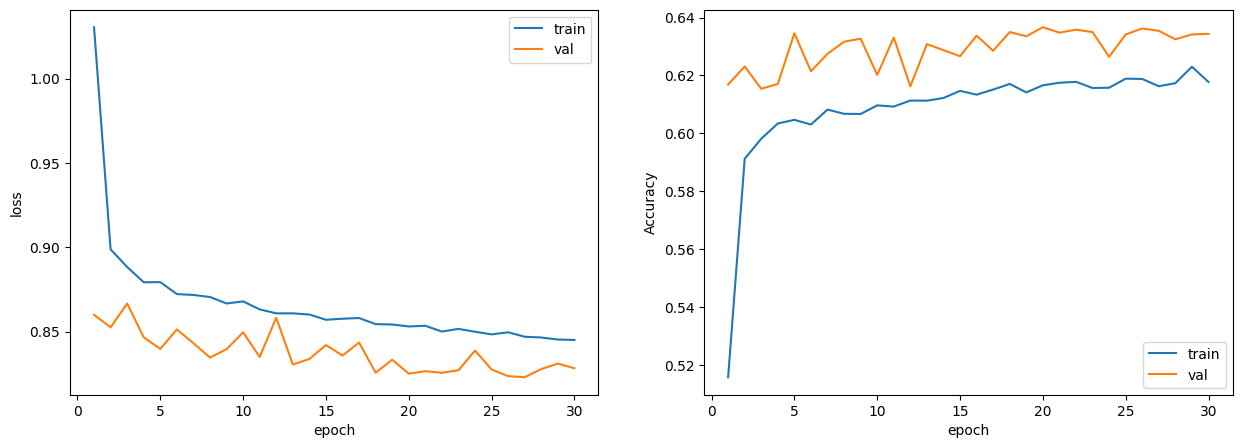

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 94/94 [00:00<00:00, 455.41it/s]


In [ ]:
steplr2 = accuracy_score(y_test, res)
print(f"Accuracy: {steplr2}")

Accuracy: 0.6318333333333334


In [ ]:
num_epochs = 50

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/50: 100%|██████████| 75/75 [00:00<00:00, 483.64it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.0242910967270533, train acc: 0.52692711353302
 val loss: 0.8846946009000143, val acc: 0.60875



Validating epoch 2/50: 100%|██████████| 75/75 [00:00<00:00, 491.09it/s]


Epoch 2
 train loss: 0.9000687460104625, train acc: 0.5904687643051147
 val loss: 0.8590100868542989, val acc: 0.6102083333333334



Validating epoch 3/50: 100%|██████████| 75/75 [00:00<00:00, 508.28it/s]


Epoch 3
 train loss: 0.8876587065060934, train acc: 0.5984895825386047
 val loss: 0.8379556465148926, val acc: 0.6266666666666667



Validating epoch 4/50: 100%|██████████| 75/75 [00:00<00:00, 455.76it/s]


Epoch 4
 train loss: 0.8855709884564081, train acc: 0.6001041531562805
 val loss: 0.8525646821657816, val acc: 0.616875



Validating epoch 5/50: 100%|██████████| 75/75 [00:00<00:00, 512.58it/s]


Epoch 5
 train loss: 0.8774856368700663, train acc: 0.6020312905311584
 val loss: 0.8350401711463928, val acc: 0.6310416666666666



Validating epoch 6/50: 100%|██████████| 75/75 [00:00<00:00, 546.87it/s]


Epoch 6
 train loss: 0.8744092470407486, train acc: 0.6065624952316284
 val loss: 0.8421489421526591, val acc: 0.6266666666666667



Validating epoch 7/50: 100%|██████████| 75/75 [00:00<00:00, 336.77it/s]


Epoch 7
 train loss: 0.8702641367912293, train acc: 0.6084895730018616
 val loss: 0.8404872528711955, val acc: 0.6210416666666667



Validating epoch 8/50: 100%|██████████| 75/75 [00:00<00:00, 343.13it/s]


Epoch 8
 train loss: 0.8728595441579818, train acc: 0.6066666841506958
 val loss: 0.8439094463984171, val acc: 0.6133333333333333



Validating epoch 9/50: 100%|██████████| 75/75 [00:00<00:00, 503.06it/s]


Epoch 9
 train loss: 0.8700619792938232, train acc: 0.6069270968437195
 val loss: 0.8474577196439107, val acc: 0.6229166666666667



Validating epoch 10/50: 100%|██████████| 75/75 [00:00<00:00, 493.63it/s]


Epoch 10
 train loss: 0.8651430724064509, train acc: 0.6098437905311584
 val loss: 0.834527603785197, val acc: 0.6241666666666666



Validating epoch 11/50: 100%|██████████| 75/75 [00:00<00:00, 533.25it/s]


Epoch 11
 train loss: 0.8647726867596308, train acc: 0.6087499856948853
 val loss: 0.8422406959533691, val acc: 0.6320833333333333



Validating epoch 12/50: 100%|██████████| 75/75 [00:00<00:00, 544.82it/s]


Epoch 12
 train loss: 0.8601669182380041, train acc: 0.6088541746139526
 val loss: 0.829104208946228, val acc: 0.633125



Validating epoch 13/50: 100%|██████████| 75/75 [00:00<00:00, 503.40it/s]


Epoch 13
 train loss: 0.8587479931116104, train acc: 0.6139583587646484
 val loss: 0.8347644758224487, val acc: 0.630625



Validating epoch 14/50: 100%|██████████| 75/75 [00:00<00:00, 490.04it/s]


Epoch 14
 train loss: 0.8588683982690175, train acc: 0.6125521063804626
 val loss: 0.8257884287834167, val acc: 0.6352083333333334



Validating epoch 15/50: 100%|██████████| 75/75 [00:00<00:00, 521.99it/s]


Epoch 15
 train loss: 0.8561226234833399, train acc: 0.6136979460716248
 val loss: 0.8266793457667033, val acc: 0.636875



Validating epoch 16/50: 100%|██████████| 75/75 [00:00<00:00, 378.65it/s]


Epoch 16
 train loss: 0.8550919612248739, train acc: 0.6152083277702332
 val loss: 0.8335174489021301, val acc: 0.6320833333333333



Validating epoch 17/50: 100%|██████████| 75/75 [00:00<00:00, 362.83it/s]


Epoch 17
 train loss: 0.8533571926752727, train acc: 0.6147916913032532
 val loss: 0.8510809246699015, val acc: 0.623125



Validating epoch 18/50: 100%|██████████| 75/75 [00:00<00:00, 525.38it/s]


Epoch 18
 train loss: 0.8510834316412608, train acc: 0.6161458492279053
 val loss: 0.828076319694519, val acc: 0.6352083333333334



Validating epoch 19/50: 100%|██████████| 75/75 [00:00<00:00, 507.41it/s]


Epoch 19
 train loss: 0.8518216248353322, train acc: 0.6172916889190674
 val loss: 0.8288961784044901, val acc: 0.6360416666666666



Validating epoch 20/50: 100%|██████████| 75/75 [00:00<00:00, 529.41it/s]


Epoch 20
 train loss: 0.8470158143838247, train acc: 0.6164583563804626
 val loss: 0.8230764516194662, val acc: 0.6395833333333333



Validating epoch 21/50: 100%|██████████| 75/75 [00:00<00:00, 489.95it/s]


Epoch 21
 train loss: 0.8477816591660182, train acc: 0.6178646087646484
 val loss: 0.8331079435348511, val acc: 0.6304166666666666



Validating epoch 22/50: 100%|██████████| 75/75 [00:00<00:00, 536.74it/s]


Epoch 22
 train loss: 0.8446385210752487, train acc: 0.6185937523841858
 val loss: 0.8297858293851217, val acc: 0.6297916666666666



Validating epoch 23/50: 100%|██████████| 75/75 [00:00<00:00, 489.09it/s]


Epoch 23
 train loss: 0.8460220024983088, train acc: 0.6192708611488342
 val loss: 0.8235085892677307, val acc: 0.6385416666666667



Validating epoch 24/50: 100%|██████████| 75/75 [00:00<00:00, 525.71it/s]


Epoch 24
 train loss: 0.8451190467675527, train acc: 0.616406261920929
 val loss: 0.820467898050944, val acc: 0.6347916666666666



Validating epoch 25/50: 100%|██████████| 75/75 [00:00<00:00, 366.35it/s]


Epoch 25
 train loss: 0.8419693861405054, train acc: 0.6227083206176758
 val loss: 0.8380678844451904, val acc: 0.631875



Validating epoch 26/50: 100%|██████████| 75/75 [00:00<00:00, 358.76it/s]


Epoch 26
 train loss: 0.840490148862203, train acc: 0.6220833659172058
 val loss: 0.8332632048924764, val acc: 0.63



Validating epoch 27/50: 100%|██████████| 75/75 [00:00<00:00, 527.08it/s]


Epoch 27
 train loss: 0.839886557062467, train acc: 0.6228646039962769
 val loss: 0.8219791865348816, val acc: 0.6314583333333333



Validating epoch 28/50: 100%|██████████| 75/75 [00:00<00:00, 527.27it/s]


Epoch 28
 train loss: 0.8404951032002766, train acc: 0.6235937476158142
 val loss: 0.8425592064857483, val acc: 0.6172916666666667



Validating epoch 29/50: 100%|██████████| 75/75 [00:00<00:00, 513.50it/s]


Epoch 29
 train loss: 0.8376070537169774, train acc: 0.6200520992279053
 val loss: 0.8253571430842082, val acc: 0.6277083333333333



Validating epoch 30/50: 100%|██████████| 75/75 [00:00<00:00, 523.20it/s]


Epoch 30
 train loss: 0.8343394986788432, train acc: 0.6230208277702332
 val loss: 0.8242599940299988, val acc: 0.6283333333333333



Validating epoch 31/50: 100%|██████████| 75/75 [00:00<00:00, 499.68it/s]


Epoch 31
 train loss: 0.8361413103342056, train acc: 0.6218229532241821
 val loss: 0.8281114912033081, val acc: 0.6310416666666666



Validating epoch 32/50: 100%|██████████| 75/75 [00:00<00:00, 510.51it/s]


Epoch 32
 train loss: 0.8333520479996999, train acc: 0.6269270777702332
 val loss: 0.8321095514297485, val acc: 0.6383333333333333



Validating epoch 33/50: 100%|██████████| 75/75 [00:00<00:00, 518.00it/s]


Epoch 33
 train loss: 0.8309618916114171, train acc: 0.6258333325386047
 val loss: 0.8245345346132914, val acc: 0.6314583333333333



Validating epoch 34/50: 100%|██████████| 75/75 [00:00<00:00, 346.54it/s]


Epoch 34
 train loss: 0.8312719374895096, train acc: 0.6272395849227905
 val loss: 0.8218660569190979, val acc: 0.64



Validating epoch 35/50: 100%|██████████| 75/75 [00:00<00:00, 350.91it/s]


Epoch 35
 train loss: 0.8304976294438045, train acc: 0.6243749856948853
 val loss: 0.8207543690999349, val acc: 0.6391666666666667



Validating epoch 36/50: 100%|██████████| 75/75 [00:00<00:00, 362.22it/s]


Epoch 36
 train loss: 0.8308727441231409, train acc: 0.6265625357627869
 val loss: 0.8241719635327657, val acc: 0.6352083333333334



Validating epoch 37/50: 100%|██████████| 75/75 [00:00<00:00, 355.25it/s]


Epoch 37
 train loss: 0.8292291988929112, train acc: 0.6292708516120911
 val loss: 0.8395274051030477, val acc: 0.6216666666666667



Validating epoch 38/50: 100%|██████████| 75/75 [00:00<00:00, 456.27it/s]


Epoch 38
 train loss: 0.828539000749588, train acc: 0.6301562786102295
 val loss: 0.8183567810058594, val acc: 0.6360416666666666



Validating epoch 39/50: 100%|██████████| 75/75 [00:00<00:00, 496.17it/s]


Epoch 39
 train loss: 0.8257136166095733, train acc: 0.6298437714576721
 val loss: 0.8249851242701213, val acc: 0.6372916666666667



Validating epoch 40/50: 100%|██████████| 75/75 [00:00<00:00, 490.84it/s]


Epoch 40
 train loss: 0.8273815747102101, train acc: 0.6298437714576721
 val loss: 0.8267934926350912, val acc: 0.6341666666666667



Validating epoch 41/50: 100%|██████████| 75/75 [00:00<00:00, 538.73it/s]


Epoch 41
 train loss: 0.8246965072552364, train acc: 0.6319270730018616
 val loss: 0.8213973919550578, val acc: 0.643125



Validating epoch 42/50: 100%|██████████| 75/75 [00:00<00:00, 363.09it/s]


Epoch 42
 train loss: 0.8231986272335052, train acc: 0.6297395825386047
 val loss: 0.8181633377075195, val acc: 0.6402083333333334



Validating epoch 43/50: 100%|██████████| 75/75 [00:00<00:00, 383.12it/s]


Epoch 43
 train loss: 0.8213767383495967, train acc: 0.6303645968437195
 val loss: 0.8190135876337687, val acc: 0.6414583333333334



Validating epoch 44/50: 100%|██████████| 75/75 [00:00<00:00, 522.41it/s]


Epoch 44
 train loss: 0.8209215734402339, train acc: 0.6332291960716248
 val loss: 0.820357604821523, val acc: 0.641875



Validating epoch 45/50: 100%|██████████| 75/75 [00:00<00:00, 513.95it/s]


Epoch 45
 train loss: 0.8208444472153982, train acc: 0.6311979293823242
 val loss: 0.8228531455993653, val acc: 0.6370833333333333



Validating epoch 46/50: 100%|██████████| 75/75 [00:00<00:00, 499.94it/s]


Epoch 46
 train loss: 0.8207960458596547, train acc: 0.6314583420753479
 val loss: 0.8194482549031575, val acc: 0.63625



Validating epoch 47/50: 100%|██████████| 75/75 [00:00<00:00, 490.03it/s]


Epoch 47
 train loss: 0.8178606410821279, train acc: 0.6330729126930237
 val loss: 0.8297075740496318, val acc: 0.630625



Validating epoch 48/50: 100%|██████████| 75/75 [00:00<00:00, 497.70it/s]


Epoch 48
 train loss: 0.8170526140928268, train acc: 0.6332291960716248
 val loss: 0.8311449559529622, val acc: 0.6333333333333333



Validating epoch 49/50: 100%|██████████| 75/75 [00:00<00:00, 511.29it/s]


Epoch 49
 train loss: 0.8164855297406515, train acc: 0.6339062452316284
 val loss: 0.8193620149294535, val acc: 0.63125



Validating epoch 50/50: 100%|██████████| 75/75 [00:00<00:00, 493.04it/s]

Epoch 50
 train loss: 0.815285174647967, train acc: 0.6327604055404663
 val loss: 0.8246931290626526, val acc: 0.635625



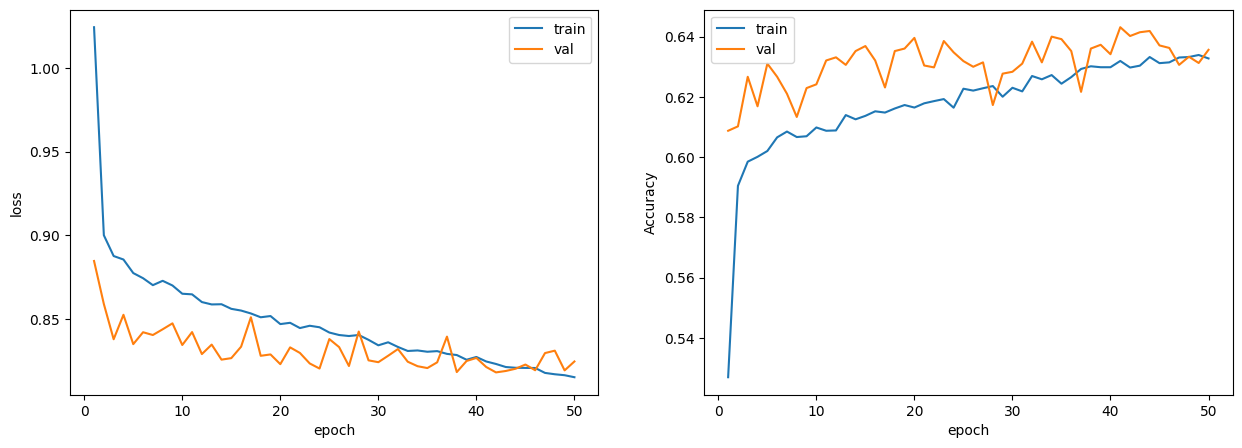

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()

Testing: 100%|██████████| 94/94 [00:00<00:00, 385.19it/s]


In [ ]:
steplr3 = accuracy_score(y_test, res)
print(f"Accuracy: {steplr3}")

Accuracy: 0.6355


In [ ]:
num_epochs = 50

batch_size = 128
dropout_prob = 0.5
hidden_size = 1024

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)


scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.15, max_lr=0.5,step_size_up=5,mode="triangular")



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)

Validating epoch 1/50: 100%|██████████| 38/38 [00:00<00:00, 64.64it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.0558815427621207, train acc: 0.5046354532241821
 val loss: 0.8650084439913431, val acc: 0.6154166666666666



Validating epoch 2/50: 100%|██████████| 38/38 [00:00<00:00, 89.27it/s]


Epoch 2
 train loss: 0.9386379623413086, train acc: 0.5715625286102295
 val loss: 0.900791388352712, val acc: 0.598125



Validating epoch 3/50: 100%|██████████| 38/38 [00:00<00:00, 82.47it/s]


Epoch 3
 train loss: 0.9044003975391388, train acc: 0.588854193687439
 val loss: 0.8637272461255392, val acc: 0.609375



Validating epoch 4/50: 100%|██████████| 38/38 [00:00<00:00, 88.77it/s]


Epoch 4
 train loss: 0.8921134797732035, train acc: 0.59333336353302
 val loss: 0.8447840245564778, val acc: 0.6216666666666667



Validating epoch 5/50: 100%|██████████| 38/38 [00:00<00:00, 89.76it/s]


Epoch 5
 train loss: 0.8894224627812704, train acc: 0.59723961353302
 val loss: 0.8394939804077148, val acc: 0.6258333333333334



Validating epoch 6/50: 100%|██████████| 38/38 [00:00<00:00, 90.78it/s]


Epoch 6
 train loss: 0.881202753384908, train acc: 0.598229169845581
 val loss: 0.8424016618728638, val acc: 0.6258333333333334



Validating epoch 7/50: 100%|██████████| 38/38 [00:00<00:00, 82.86it/s]


Epoch 7
 train loss: 0.8800256228446961, train acc: 0.5980729460716248
 val loss: 0.850124113559723, val acc: 0.619375



Validating epoch 8/50: 100%|██████████| 38/38 [00:00<00:00, 90.02it/s]


Epoch 8
 train loss: 0.8728169135252635, train acc: 0.6016666889190674
 val loss: 0.8586771400769552, val acc: 0.6202083333333334



Validating epoch 9/50: 100%|██████████| 38/38 [00:00<00:00, 90.26it/s]


Epoch 9
 train loss: 0.8712662327289581, train acc: 0.6027604341506958
 val loss: 0.8521818065643311, val acc: 0.6204166666666666



Validating epoch 10/50: 100%|██████████| 38/38 [00:00<00:00, 89.33it/s]


Epoch 10
 train loss: 0.8657045698165894, train acc: 0.6101042032241821
 val loss: 0.8370343478520711, val acc: 0.6233333333333333



Validating epoch 11/50: 100%|██████████| 38/38 [00:00<00:00, 83.89it/s]


Epoch 11
 train loss: 0.8685480856895447, train acc: 0.6061458587646484
 val loss: 0.8338257034619649, val acc: 0.6302083333333334



Validating epoch 12/50: 100%|██████████| 38/38 [00:00<00:00, 88.83it/s]


Epoch 12
 train loss: 0.8662046134471894, train acc: 0.6088541746139526
 val loss: 0.833752543926239, val acc: 0.6258333333333334



Validating epoch 13/50: 100%|██████████| 38/38 [00:00<00:00, 88.19it/s]


Epoch 13
 train loss: 0.8656995419661204, train acc: 0.6072916984558105
 val loss: 0.844103852113088, val acc: 0.62875



Validating epoch 14/50: 100%|██████████| 38/38 [00:00<00:00, 83.17it/s]


Epoch 14
 train loss: 0.8639198013146718, train acc: 0.60916668176651
 val loss: 0.8374054066340129, val acc: 0.625



Validating epoch 15/50: 100%|██████████| 38/38 [00:00<00:00, 82.61it/s]


Epoch 15
 train loss: 0.8608863226572673, train acc: 0.6105729341506958
 val loss: 0.8455398488044739, val acc: 0.6272916666666667



Validating epoch 16/50: 100%|██████████| 38/38 [00:00<00:00, 89.34it/s]


Epoch 16
 train loss: 0.8596352970600128, train acc: 0.6106250286102295
 val loss: 0.8272317616144816, val acc: 0.6302083333333334



Validating epoch 17/50: 100%|██████████| 38/38 [00:00<00:00, 88.30it/s]


Epoch 17
 train loss: 0.8575891347726187, train acc: 0.6113020777702332
 val loss: 0.8281323385238647, val acc: 0.6335416666666667



Validating epoch 18/50: 100%|██████████| 38/38 [00:00<00:00, 81.50it/s]


Epoch 18
 train loss: 0.8558504958947499, train acc: 0.612083375453949
 val loss: 0.8373250945409139, val acc: 0.6291666666666667



Validating epoch 19/50: 100%|██████████| 38/38 [00:00<00:00, 89.22it/s]


Epoch 19
 train loss: 0.8550307810306549, train acc: 0.6160937547683716
 val loss: 0.8285469150543213, val acc: 0.638125



Validating epoch 20/50: 100%|██████████| 38/38 [00:00<00:00, 90.35it/s]


Epoch 20
 train loss: 0.8558976789315541, train acc: 0.6106771230697632
 val loss: 0.8257936437924703, val acc: 0.6347916666666666



Validating epoch 21/50: 100%|██████████| 38/38 [00:00<00:00, 88.85it/s]


Epoch 21
 train loss: 0.8494034377733867, train acc: 0.6193749904632568
 val loss: 0.8238282823562622, val acc: 0.6304166666666666



Validating epoch 22/50: 100%|██████████| 38/38 [00:00<00:00, 82.97it/s]


Epoch 22
 train loss: 0.8520691192150116, train acc: 0.6163020730018616
 val loss: 0.8396297494570414, val acc: 0.6285416666666667



Validating epoch 23/50: 100%|██████████| 38/38 [00:00<00:00, 90.01it/s]


Epoch 23
 train loss: 0.8491322330633799, train acc: 0.6150521039962769
 val loss: 0.8275115585327149, val acc: 0.6335416666666667



Validating epoch 24/50: 100%|██████████| 38/38 [00:00<00:00, 90.37it/s]


Epoch 24
 train loss: 0.8482272688547771, train acc: 0.6154687404632568
 val loss: 0.8235115758577982, val acc: 0.6391666666666667



Validating epoch 25/50: 100%|██████████| 38/38 [00:00<00:00, 81.60it/s]


Epoch 25
 train loss: 0.8463942583401998, train acc: 0.617968738079071
 val loss: 0.8200071342786153, val acc: 0.6370833333333333



Validating epoch 26/50: 100%|██████████| 38/38 [00:00<00:00, 80.90it/s]


Epoch 26
 train loss: 0.8463948901494344, train acc: 0.6196874976158142
 val loss: 0.8407116222381592, val acc: 0.6291666666666667



Validating epoch 27/50: 100%|██████████| 38/38 [00:00<00:00, 88.74it/s]


Epoch 27
 train loss: 0.8453223554293314, train acc: 0.6197916865348816
 val loss: 0.8231987730662028, val acc: 0.636875



Validating epoch 28/50: 100%|██████████| 38/38 [00:00<00:00, 89.24it/s]


Epoch 28
 train loss: 0.842239873011907, train acc: 0.6176041960716248
 val loss: 0.8249222763379415, val acc: 0.633125



Validating epoch 29/50: 100%|██████████| 38/38 [00:00<00:00, 89.43it/s]


Epoch 29
 train loss: 0.8433092927932739, train acc: 0.6207292079925537
 val loss: 0.8370002826054891, val acc: 0.6304166666666666



Validating epoch 30/50: 100%|██████████| 38/38 [00:00<00:00, 81.69it/s]


Epoch 30
 train loss: 0.8427428030967712, train acc: 0.6219270825386047
 val loss: 0.8371271896362305, val acc: 0.6239583333333333



Validating epoch 31/50: 100%|██████████| 38/38 [00:00<00:00, 88.30it/s]


Epoch 31
 train loss: 0.8423270710309346, train acc: 0.6191666722297668
 val loss: 0.819770069917043, val acc: 0.6379166666666667



Validating epoch 32/50: 100%|██████████| 38/38 [00:00<00:00, 88.75it/s]


Epoch 32
 train loss: 0.8396828703085581, train acc: 0.6214062571525574
 val loss: 0.8394804453849792, val acc: 0.6308333333333334



Validating epoch 33/50: 100%|██████████| 38/38 [00:00<00:00, 82.46it/s]


Epoch 33
 train loss: 0.8383065136273702, train acc: 0.6220833659172058
 val loss: 0.8474496642748515, val acc: 0.6227083333333333



Validating epoch 34/50: 100%|██████████| 38/38 [00:00<00:00, 83.47it/s]


Epoch 34
 train loss: 0.8363853307565053, train acc: 0.6239062547683716
 val loss: 0.8192296489079793, val acc: 0.645



Validating epoch 35/50: 100%|██████████| 38/38 [00:00<00:00, 88.84it/s]


Epoch 35
 train loss: 0.8344359664122264, train acc: 0.625
 val loss: 0.8239492797851562, val acc: 0.6358333333333334



Validating epoch 36/50: 100%|██████████| 38/38 [00:00<00:00, 89.25it/s]


Epoch 36
 train loss: 0.8331800377368928, train acc: 0.6266145706176758
 val loss: 0.8186224126815795, val acc: 0.6395833333333333



Validating epoch 37/50: 100%|██████████| 38/38 [00:00<00:00, 84.36it/s]


Epoch 37
 train loss: 0.8347512865066529, train acc: 0.6253646016120911
 val loss: 0.821457675298055, val acc: 0.638125



Validating epoch 38/50: 100%|██████████| 38/38 [00:00<00:00, 88.22it/s]


Epoch 38
 train loss: 0.8327661844094595, train acc: 0.62890625
 val loss: 0.8252433808644613, val acc: 0.63625



Validating epoch 39/50: 100%|██████████| 38/38 [00:00<00:00, 89.10it/s]


Epoch 39
 train loss: 0.835104280312856, train acc: 0.6232812404632568
 val loss: 0.8273912350336711, val acc: 0.6308333333333334



Validating epoch 40/50: 100%|██████████| 38/38 [00:00<00:00, 89.92it/s]


Epoch 40
 train loss: 0.8300070671240488, train acc: 0.6260937452316284
 val loss: 0.823469877243042, val acc: 0.6354166666666666



Validating epoch 41/50: 100%|██████████| 38/38 [00:00<00:00, 79.91it/s]


Epoch 41
 train loss: 0.832550200621287, train acc: 0.6256771087646484
 val loss: 0.8246373661359151, val acc: 0.6358333333333334



Validating epoch 42/50: 100%|██████████| 38/38 [00:00<00:00, 88.03it/s]


Epoch 42
 train loss: 0.8292045255502065, train acc: 0.6274999976158142
 val loss: 0.8230848058064779, val acc: 0.6352083333333334



Validating epoch 43/50: 100%|██████████| 38/38 [00:00<00:00, 89.42it/s]


Epoch 43
 train loss: 0.8292105813821157, train acc: 0.6272916793823242
 val loss: 0.8193017411231994, val acc: 0.638125



Validating epoch 44/50: 100%|██████████| 38/38 [00:00<00:00, 84.93it/s]


Epoch 44
 train loss: 0.8283515059947968, train acc: 0.6292187571525574
 val loss: 0.819308602809906, val acc: 0.6377083333333333



Validating epoch 45/50: 100%|██████████| 38/38 [00:00<00:00, 84.29it/s]


Epoch 45
 train loss: 0.8270354175567627, train acc: 0.6285417079925537
 val loss: 0.8288089028994242, val acc: 0.6325



Validating epoch 46/50: 100%|██████████| 38/38 [00:00<00:00, 88.53it/s]


Epoch 46
 train loss: 0.8253149648507436, train acc: 0.6294270753860474
 val loss: 0.8220917463302613, val acc: 0.6358333333333334



Validating epoch 47/50: 100%|██████████| 38/38 [00:00<00:00, 89.79it/s]


Epoch 47
 train loss: 0.8235497657457987, train acc: 0.6301562786102295
 val loss: 0.8221786562601725, val acc: 0.63625



Validating epoch 48/50: 100%|██████████| 38/38 [00:00<00:00, 84.39it/s]


Epoch 48
 train loss: 0.8242516684532165, train acc: 0.6274479031562805
 val loss: 0.8256274096171061, val acc: 0.6339583333333333



Validating epoch 49/50: 100%|██████████| 38/38 [00:00<00:00, 90.29it/s]


Epoch 49
 train loss: 0.8208701368172964, train acc: 0.6288541555404663
 val loss: 0.822403028011322, val acc: 0.6395833333333333



Validating epoch 50/50: 100%|██████████| 38/38 [00:00<00:00, 90.20it/s]

Epoch 50
 train loss: 0.819576149781545, train acc: 0.6316666603088379
 val loss: 0.8208403062820434, val acc: 0.6354166666666666



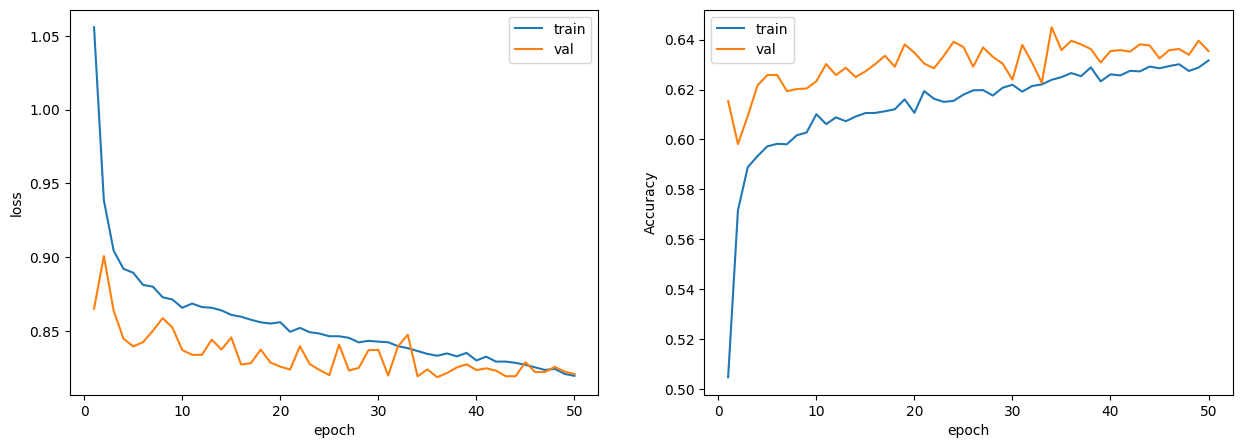

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()

Testing: 100%|██████████| 94/94 [00:00<00:00, 193.58it/s]


In [ ]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")

Accuracy: 0.6271666666666667
